# Another attempt at fitting splines with PyMC3

## Setup

In [1]:
import re
from pathlib import Path
from typing import Optional

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import scipy.stats as st
import seaborn as sns
from aesara import tensor as at
from patsy import DesignMatrix, build_design_matrices, dmatrix

In [2]:
from speclet.io import data_dir

In [3]:
pm.__version__

'4.0.0b2'

In [4]:
# Set default theme for 'plotnine'.
gg.theme_set(gg.theme_minimal() + gg.theme(figure_size=(8, 4)))
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Constants
RANDOM_SEED = 847
HDI_PROB = 0.89

## Single spline

### Data

In [5]:
def diff_of_gaussians(
    x: np.ndarray,
    mus: tuple[float, float],
    sds: tuple[float, float],
    noise: float,
    y_offset: float = 0.0,
) -> pd.DataFrame:
    y = (
        st.norm.pdf(x, mus[0], sds[0])
        - st.norm.pdf(x, mus[1], sds[1])
        + np.random.normal(0, noise, size=len(x))
    )
    return pd.DataFrame({"x": x, "y": y + y_offset})

In [6]:
group_pal = {"a": "#1F77B4", "b": "#FF7F0E"}

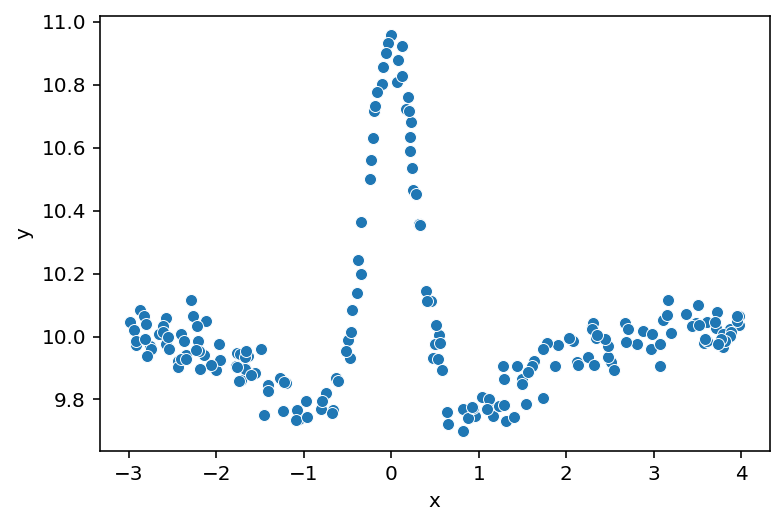

In [7]:
np.random.seed(RANDOM_SEED)

x = np.random.uniform(-3, 4, 200)
data = diff_of_gaussians(x, (0, 0), (0.3, 1), 0.05, y_offset=10)

sns.scatterplot(data=data, x="x", y="y");

### Spline basis

In [8]:
def _make_knot_list(data: pd.DataFrame, num_knots: int = 10) -> np.ndarray:
    return np.quantile(data.x, np.linspace(0, 1, num_knots))


def _build_spline(
    data: pd.DataFrame, knot_list: Optional[np.ndarray] = None, num_knots: int = 10
) -> tuple[np.ndarray, DesignMatrix]:
    if knot_list is None:
        knot_list = _make_knot_list(data, num_knots)

    B = dmatrix(
        "0 + bs(x, knots=knots, degree=3, include_intercept=False)",
        {"x": data.x.values, "knots": knot_list[1:-1]},
    )
    return knot_list, B

In [9]:
knots, B = _build_spline(data)

In [10]:
knots

array([-2.98089976, -2.36504627, -1.67490314, -0.72551484, -0.04744339,
        0.50477523,  1.30390392,  2.31655179,  3.43279987,  3.97389701])

In [11]:
B

DesignMatrix with shape (200, 11)
  Columns:
    ['bs(x, knots=knots, degree=3, include_intercept=False)[0]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[1]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[2]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[3]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[4]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[5]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[6]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[7]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[8]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[9]',
     'bs(x, knots=knots, degree=3, include_intercept=False)[10]']
  Terms:
    'bs(x, knots=knots, degree=3, include_intercept=False)' (columns 0:11)
  (to view full data, use np.asarray(this_obj))

In [12]:
np.asarray(B).shape

(200, 11)

In [13]:
data.shape

(200, 2)

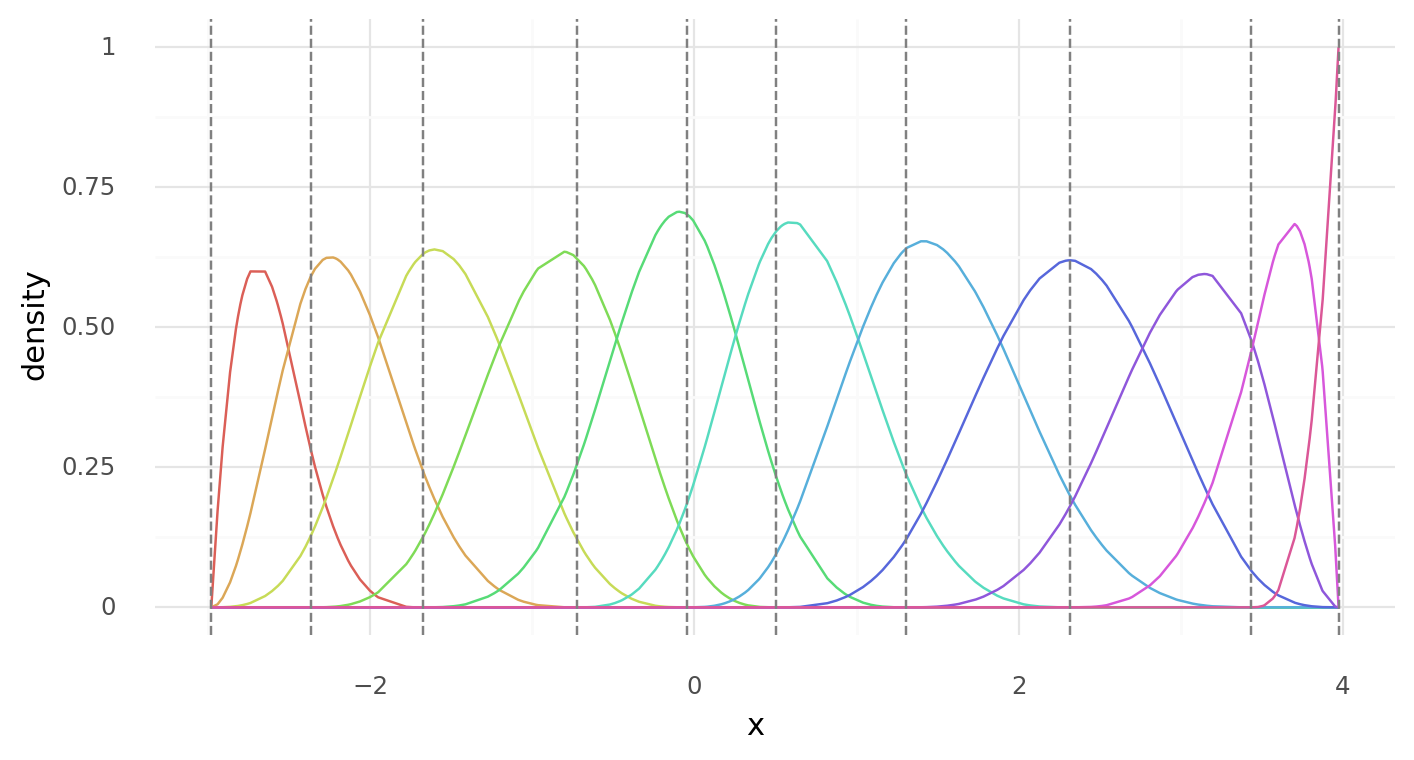

<ggplot: (343458301)>

In [14]:
basis_df = (
    pd.DataFrame(B)
    .reset_index(drop=False)
    .assign(x=data.x.values)
    .pivot_longer(index=["index", "x"], names_to="basis", values_to="density")
)

(
    gg.ggplot(basis_df, gg.aes(x="x", y="density", color="basis"))
    + gg.geom_line()
    + gg.geom_vline(xintercept=knots, color="gray", linetype="--")
    + gg.theme(legend_position="none")
)

### Model #1

In [15]:
def build_model1(data: pd.DataFrame, B: DesignMatrix) -> pm.Model:
    B_dim = B.shape[1]
    with pm.Model(rng_seeder=RANDOM_SEED) as m1:
        a = pm.Normal("a", 0, 5)
        w = pm.Normal("w", 0, 5, shape=B_dim)
        mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y)
    return m1

### Prior predictive

In [16]:
def _build_new_data(
    data: pd.DataFrame, B: DesignMatrix, knots: np.ndarray, n_x: int = 500
) -> tuple[pd.DataFrame, DesignMatrix]:
    new_data = pd.DataFrame(
        {"x": np.linspace(data.x.min(), data.x.max(), num=n_x)}
    ).assign(y=0)
    new_B = build_design_matrices(
        [B.design_info], {"x": new_data.x.values, "knots": knots[1:-1]}
    )[0]
    return new_data, new_B

In [17]:
def _plot_prior(
    prior_pred: az.InferenceData, var_name: str, data: pd.DataFrame
) -> None:
    if var_name == "y":
        var_prior = prior_pred.prior_predictive[var_name].values
    else:
        var_prior = prior_pred.prior[var_name].values
    var_prior = var_prior.squeeze()
    prior_df = (
        pd.DataFrame(var_prior.T)
        .reset_index(drop=False)
        .assign(x=data.x)
        .pivot_longer(["index", "x"], names_to="prior_sample")
        .astype({"prior_sample": str})
    )

    sns.lineplot(data=prior_df, x="x", y="value", hue="prior_sample", legend=None)
    plt.show()

In [18]:
new_data, new_B = _build_new_data(data=data, B=B, knots=knots)

In [19]:
with build_model1(data=new_data, B=new_B):
    m1_prior_pred = pm.sample_prior_predictive(samples=10, return_inferencedata=True)

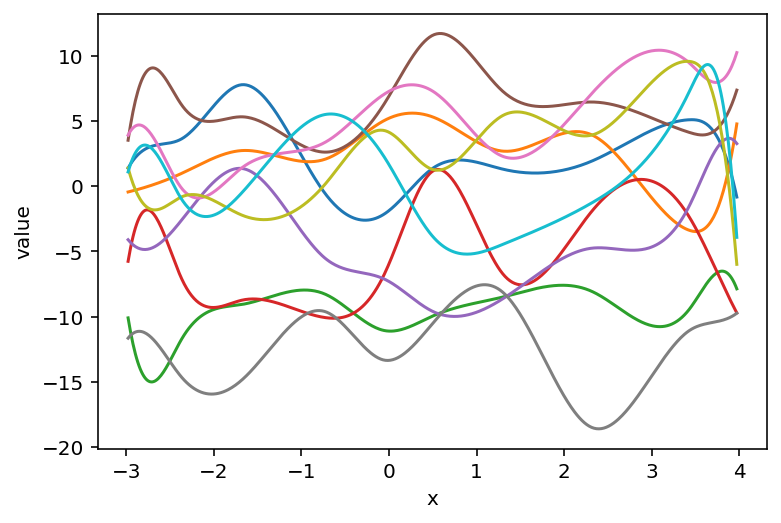

In [20]:
_plot_prior(m1_prior_pred, "mu", data=new_data)

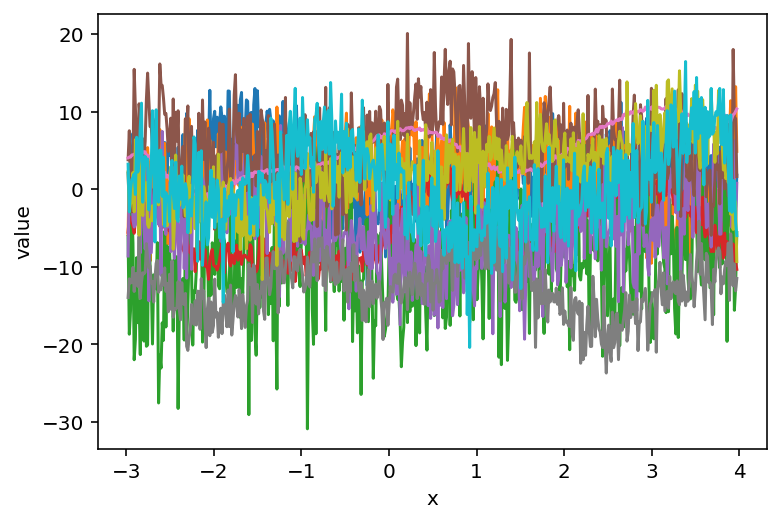

In [21]:
_plot_prior(m1_prior_pred, "y", data=new_data)

### Sample from posterior

In [22]:
pm_sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "return_inferencedata": True,
}
pm_ppc_kwargs = {"extend_inferencedata": True, "progressbar": False}

In [23]:
with build_model1(data=data, B=B):
    m1_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m1_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior analysis

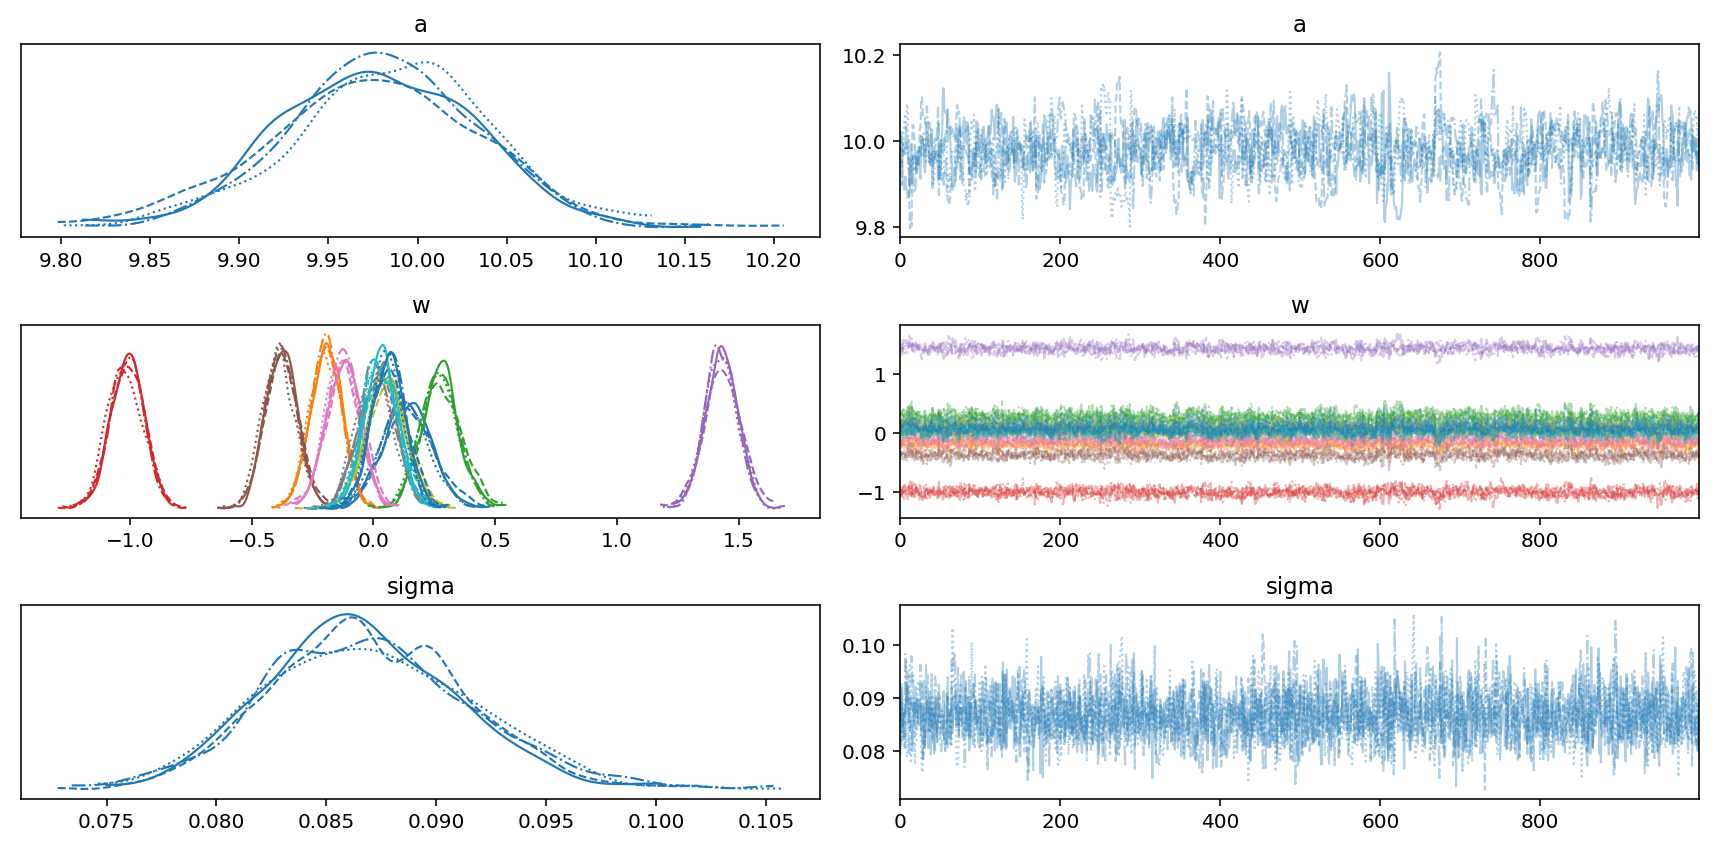

In [24]:
az.plot_trace(m1_trace, var_names=["~mu"])
plt.tight_layout();

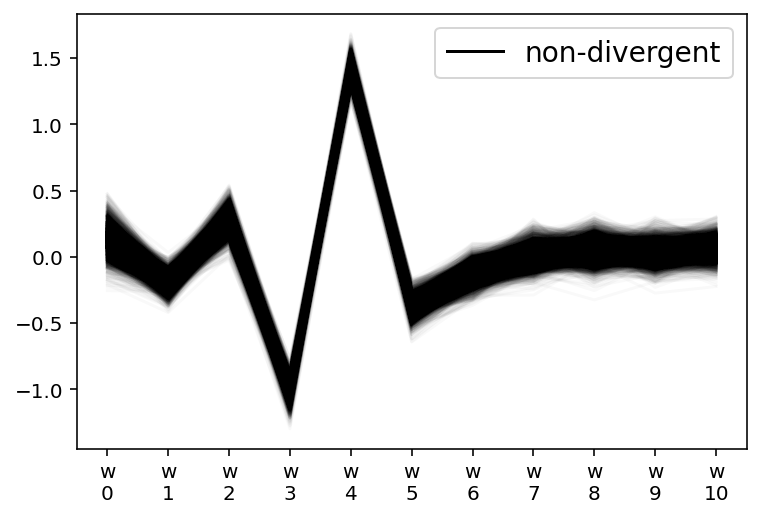

In [25]:
az.plot_parallel(m1_trace, var_names=["w"]);

In [26]:
az.summary(m1_trace, var_names=["~mu"], filter_vars="regex")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      9.980  0.056   9.873   10.083      0.002    0.001     726.0     617.0   
w[0]   0.137  0.102  -0.055    0.324      0.004    0.003     826.0    1059.0   
w[1]  -0.195  0.064  -0.311   -0.073      0.002    0.001    1525.0    2160.0   
w[2]   0.275  0.080   0.133    0.435      0.003    0.002     873.0    1350.0   
w[3]  -1.014  0.071  -1.148   -0.884      0.002    0.001    1134.0    1710.0   
w[4]   1.430  0.069   1.299    1.561      0.002    0.002     966.0    1494.0   
w[5]  -0.381  0.068  -0.512   -0.259      0.002    0.002     910.0    1186.0   
w[6]  -0.125  0.070  -0.257    0.004      0.002    0.002    1015.0    1538.0   
w[7]   0.014  0.077  -0.131    0.151      0.002    0.002    1038.0    1285.0   
w[8]   0.053  0.081  -0.099    0.207      0.002    0.002    1214.0    1848.0   
w[9]   0.030  0.073  -0.104    0.168      0.002    0.002    1013.0    1167.0   
w[10]  0.061  0.071  -0.067    0.201      0.002    0.002    1006.0    1328.0   
sigma  0.087  0.005   0.078    0.095      0.000    0.000    2692.0    2621.0   

       r_hat  
a       1.01  
w[0]    1.01  
w[1]    1.00  
w[2]    1.01  
w[3]    1.00  
w[4]    1.00  
w[5]    1.01  
w[6]    1.00  
w[7]    1.00  
w[8]    1.00  
w[9]    1.00  
w[10]   1.01  
sigma   1.00

In [27]:
def _plot_posterior_mu(
    trace: az.InferenceData, data: pd.DataFrame, pt_alpha: float = 0.5
) -> gg.ggplot:
    mu_post_df = (
        az.summary(trace, var_names="mu", hdi_prob=HDI_PROB, kind="stats")
        .reset_index(drop=True)
        .merge(data.copy(), left_index=True, right_index=True)
    )

    if "k" not in data.columns:
        mu_post_df["k"] = "a"

    return (
        gg.ggplot(mu_post_df, gg.aes(x="x"))
        + gg.geom_point(gg.aes(y="y", color="k"), alpha=pt_alpha)
        + gg.geom_ribbon(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", fill="k"), alpha=0.5)
        + gg.geom_line(gg.aes(y="mean", color="k"), size=0.5)
        + gg.scale_color_manual(group_pal)
        + gg.scale_fill_manual(group_pal)
    )

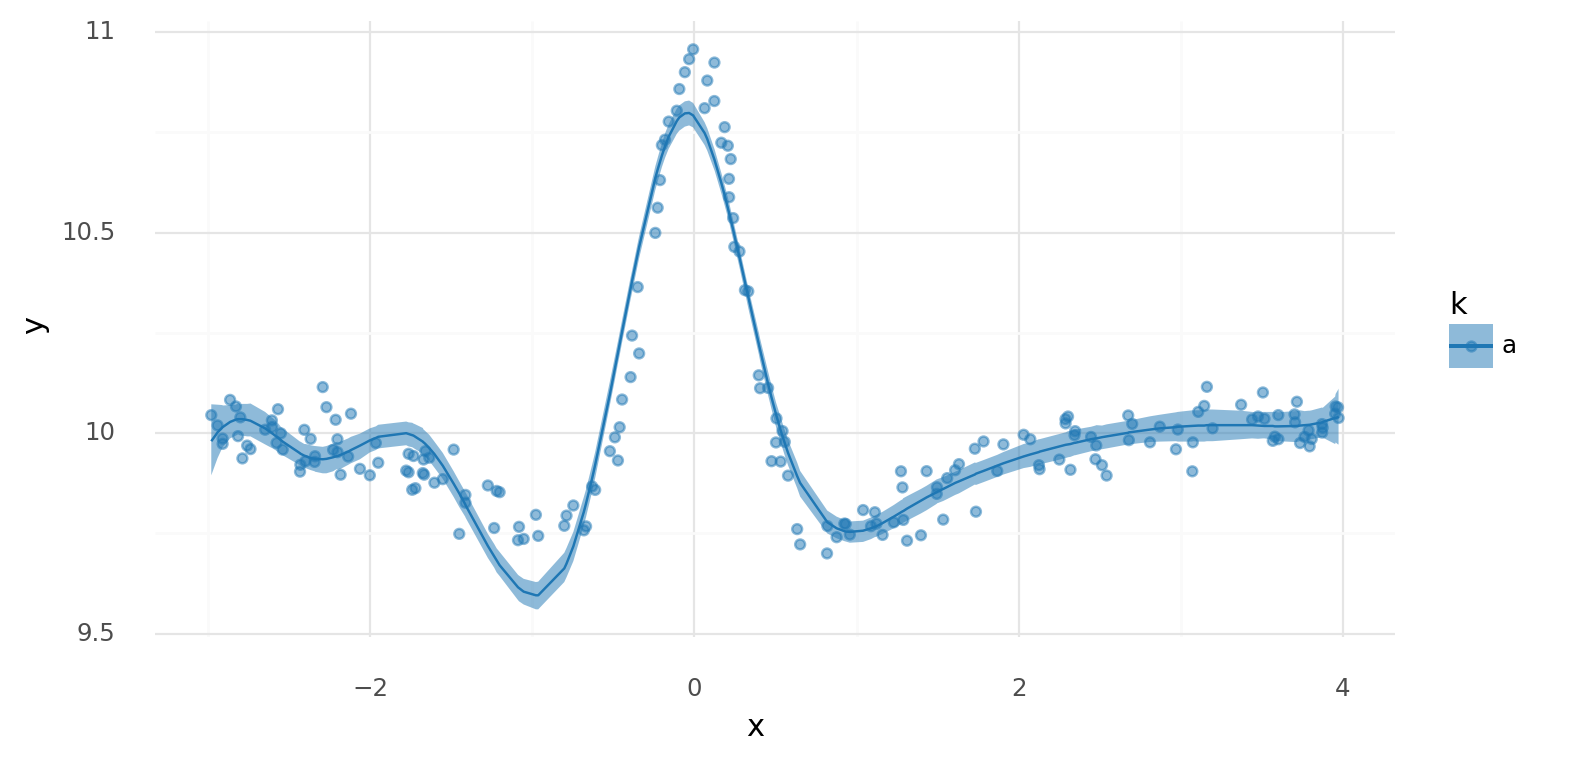

<ggplot: (348727884)>

In [28]:
_plot_posterior_mu(m1_trace, data=data)

In [29]:
def _plot_ppc(
    trace: az.InferenceData, data: pd.DataFrame, pt_alpha: float = 0.5
) -> gg.ggplot:
    post_pred = trace.posterior_predictive["y"].values.reshape(-1, data.shape[0])
    ppc_avg = post_pred.mean(0)
    ppc_hdi = az.hdi(post_pred, hdi_prob=HDI_PROB)

    plot_df = data.copy().assign(
        post_pred=ppc_avg, hdi_low=ppc_hdi[:, 0], hdi_high=ppc_hdi[:, 1]
    )

    if "k" not in data.columns:
        plot_df["k"] = np.repeat(["a"], plot_df.shape[0])

    return (
        gg.ggplot(plot_df, gg.aes(x="x"))
        + gg.geom_point(gg.aes(y="y", color="k"), alpha=pt_alpha)
        + gg.geom_ribbon(gg.aes(ymin="hdi_low", ymax="hdi_high", fill="k"), alpha=0.5)
        + gg.geom_line(gg.aes(y="post_pred", color="k"), size=1)
        + gg.scale_color_manual(group_pal)
        + gg.scale_fill_manual(group_pal)
    )

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_2877/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


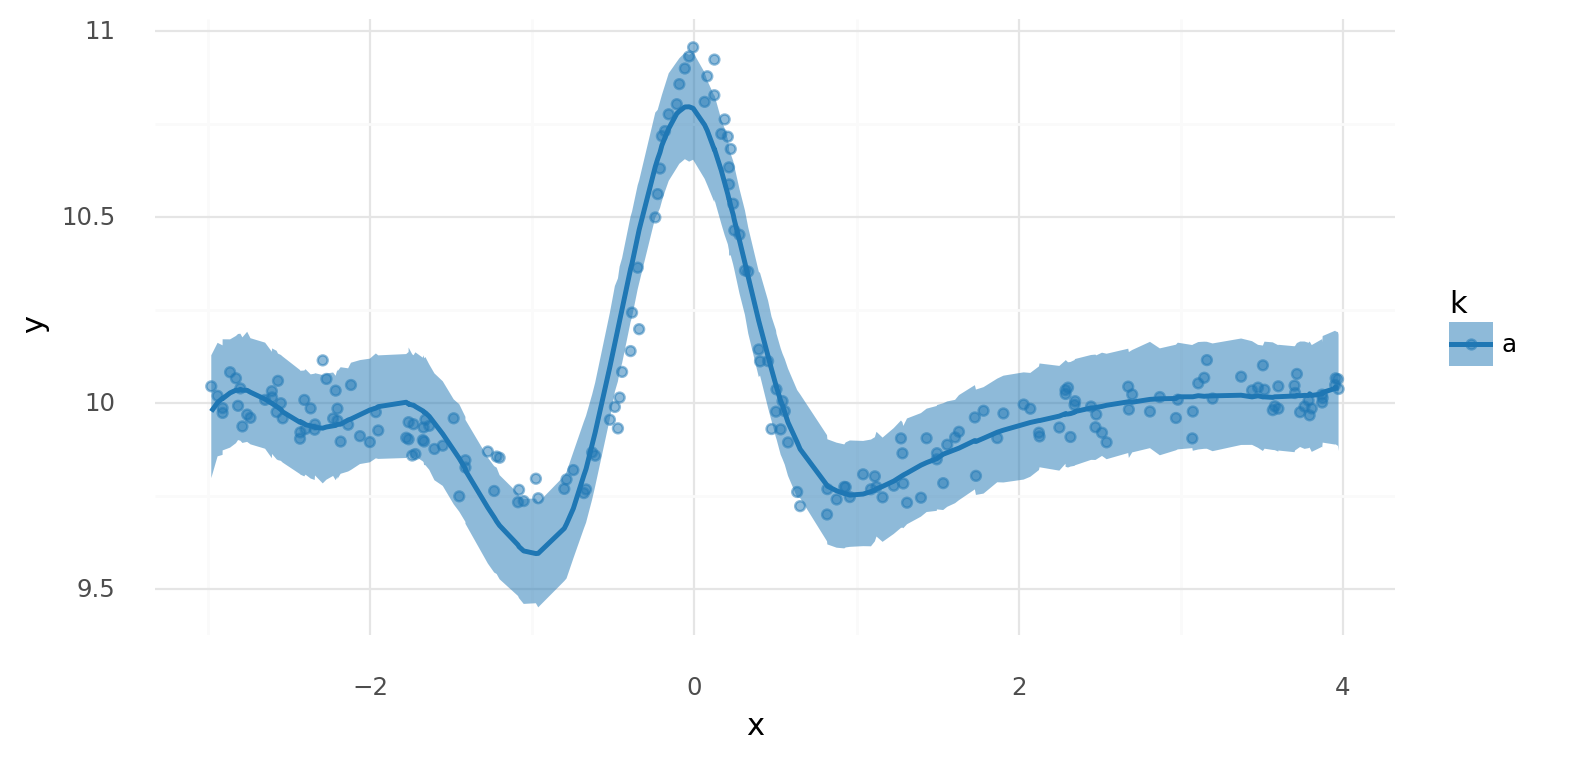

<ggplot: (348773130)>

In [30]:
_plot_ppc(m1_trace, data)

## Two groups, single spline

### Data

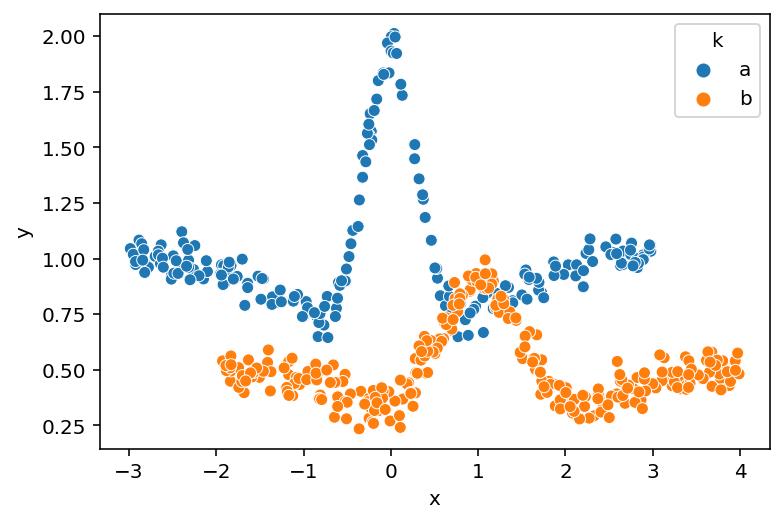

In [31]:
np.random.seed(RANDOM_SEED)

x1 = np.random.uniform(-3, 3, 200)
d1 = diff_of_gaussians(x1, (0, 0), (0.3, 1), 0.05, y_offset=1).assign(k="a")
x2 = np.random.uniform(-3, 3, 300) + 1
d2 = diff_of_gaussians(x2, (1, 1), (0.5, 1), 0.05, y_offset=0.5).assign(k="b")

data2 = pd.concat([d1, d2]).reset_index(drop=True)
data2["k"] = pd.Categorical(data2["k"], categories=["a", "b"], ordered=True)

sns.scatterplot(data=data2, x="x", y="y", hue="k", palette=group_pal);

### Spline basis

In [32]:
knots2, B2 = _build_spline(data2)

### Sample from posterior

In [33]:
with build_model1(data=data2, B=B2):
    m1_trace2 = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m1_trace2, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior analysis

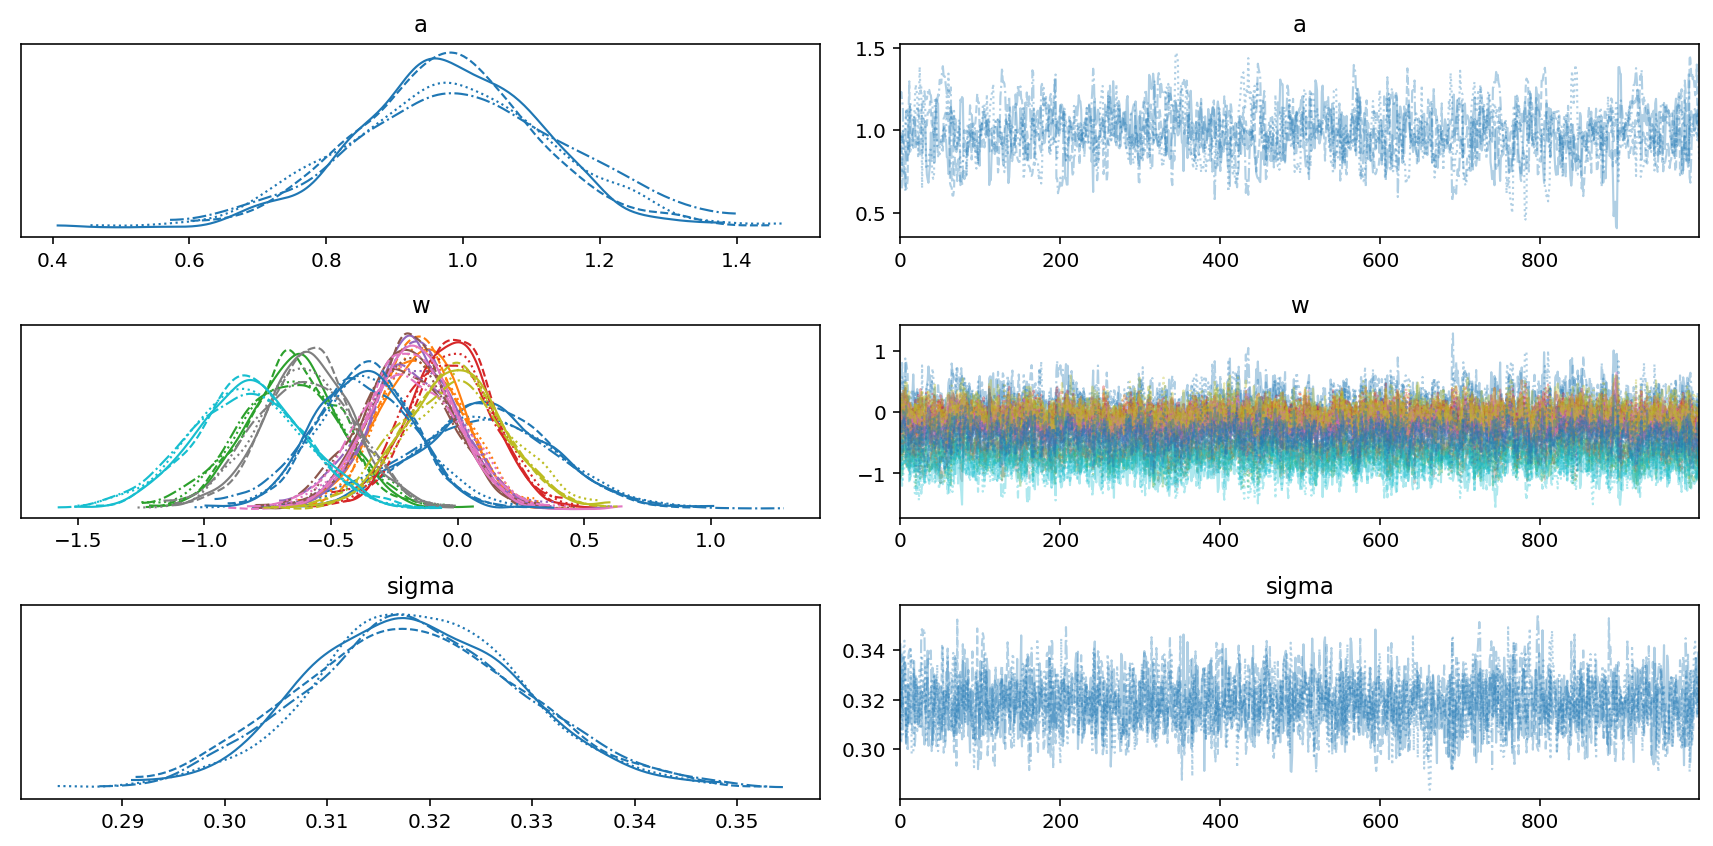

In [34]:
az.plot_trace(m1_trace2, var_names=["~mu"])
plt.tight_layout();

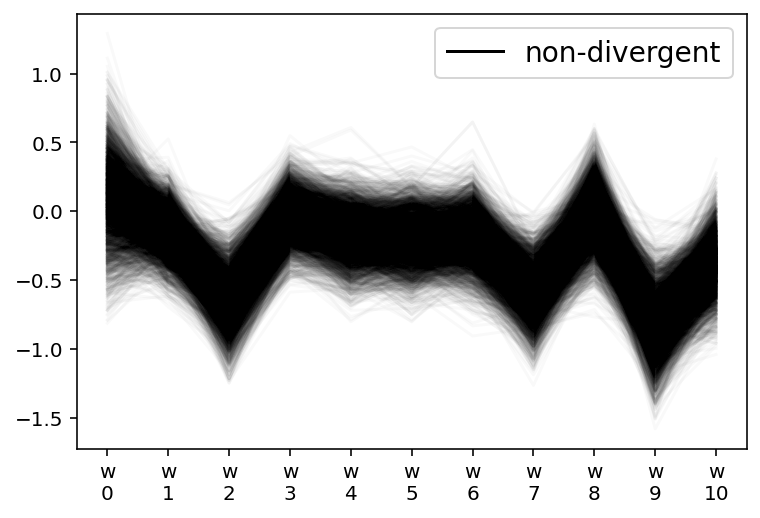

In [35]:
az.plot_parallel(m1_trace2, var_names=["w"]);

In [36]:
az.summary(m1_trace2, var_names=["~mu"], filter_vars="regex")

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      0.984  0.147   0.704    1.263      0.006    0.004     567.0     823.0   
w[0]   0.096  0.284  -0.440    0.621      0.011    0.008     692.0    1079.0   
w[1]  -0.150  0.165  -0.437    0.171      0.005    0.003    1214.0    2063.0   
w[2]  -0.652  0.195  -1.014   -0.278      0.007    0.005     717.0    1016.0   
w[3]  -0.028  0.165  -0.329    0.284      0.006    0.004     749.0    1299.0   
w[4]  -0.175  0.176  -0.516    0.143      0.006    0.005     742.0    1062.0   
w[5]  -0.196  0.175  -0.523    0.123      0.006    0.005     768.0     893.0   
w[6]  -0.182  0.181  -0.521    0.151      0.006    0.005     797.0    1330.0   
w[7]  -0.596  0.186  -0.948   -0.251      0.007    0.005     784.0    1510.0   
w[8]  -0.013  0.204  -0.393    0.366      0.007    0.005     915.0    1980.0   
w[9]  -0.829  0.220  -1.222   -0.390      0.007    0.005    1078.0    2062.0   
w[10] -0.370  0.196  -0.736    0.002      0.007    0.005     836.0    1417.0   
sigma  0.319  0.011   0.298    0.338      0.000    0.000    2522.0    2137.0   

       r_hat  
a       1.01  
w[0]    1.00  
w[1]    1.00  
w[2]    1.01  
w[3]    1.00  
w[4]    1.01  
w[5]    1.00  
w[6]    1.01  
w[7]    1.00  
w[8]    1.00  
w[9]    1.00  
w[10]   1.00  
sigma   1.00

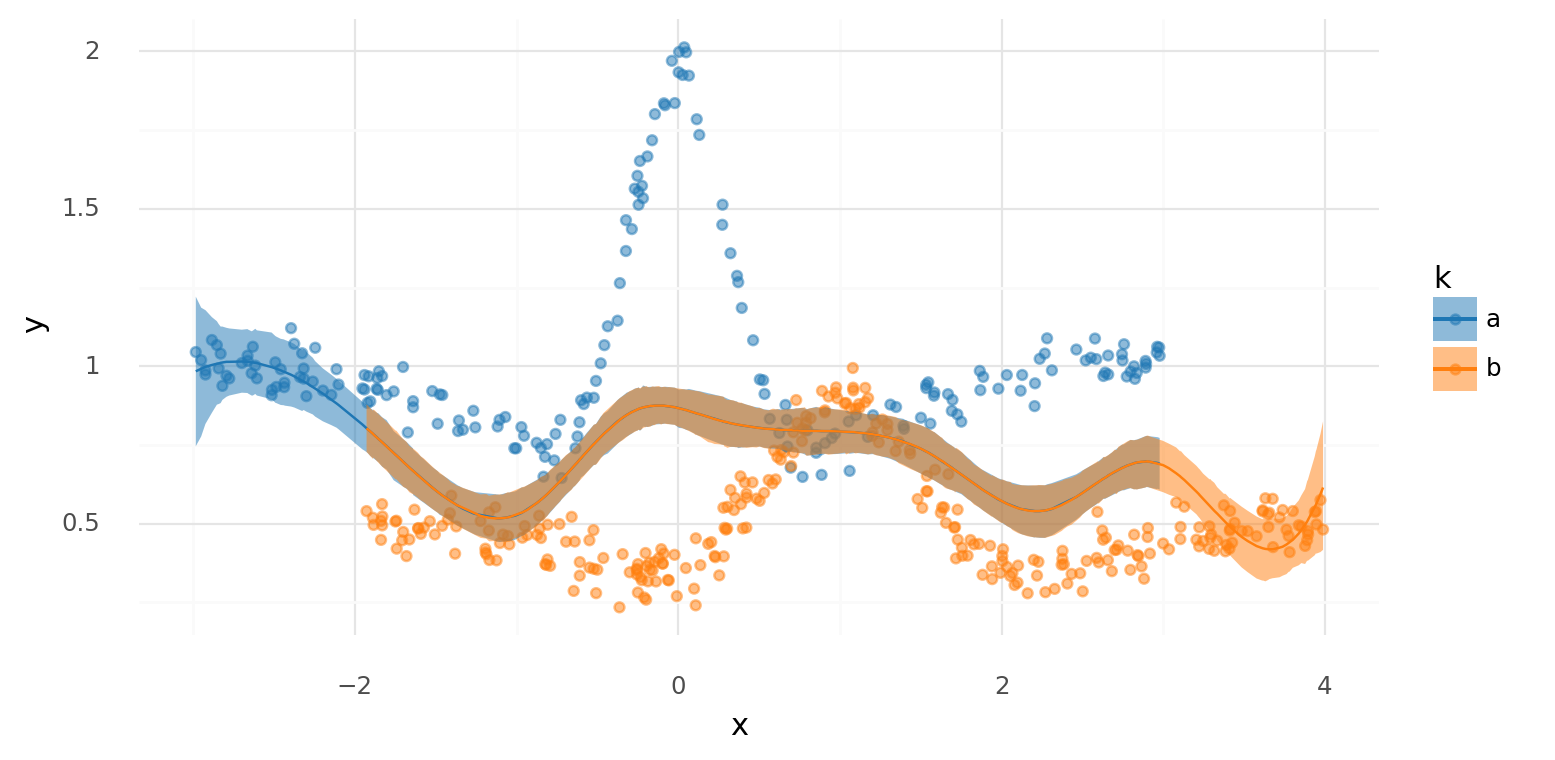

<ggplot: (347724183)>

In [37]:
_plot_posterior_mu(m1_trace2, data=data2)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_2877/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


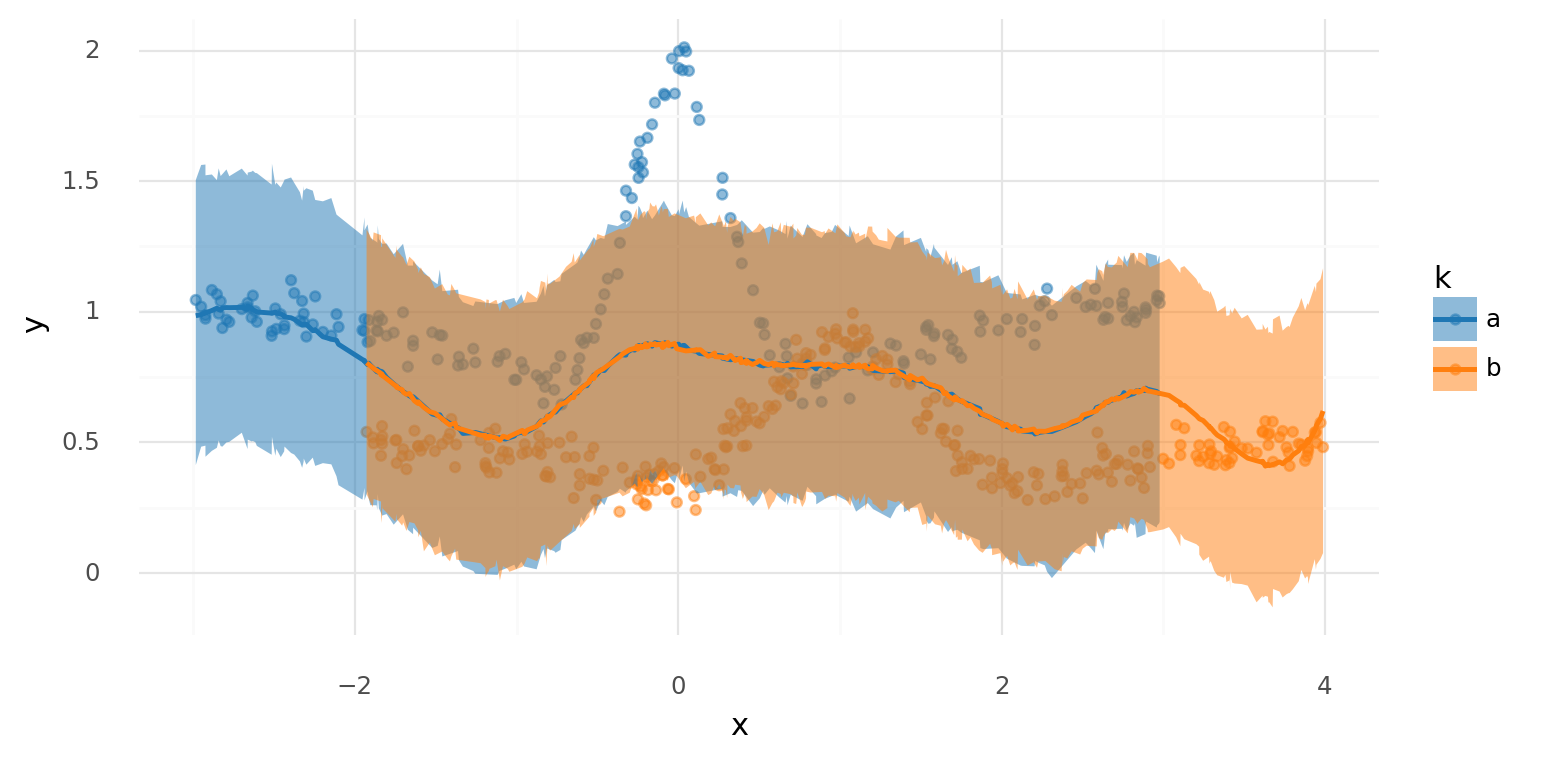

<ggplot: (347510983)>

In [38]:
_plot_ppc(m1_trace2, data2)

## Multi-group, multi-basis spline

### Spline basis

In [39]:
knots3 = _make_knot_list(data2)

In [40]:
spline_list: list[DesignMatrix] = []
for k in data2.k.unique():
    data_k = data2.query(f"k=='{k}'").reset_index(drop=True)
    _, B_k = _build_spline(data_k, knot_list=knots3)
    spline_list.append(B_k)

print(len(spline_list))

2


In [41]:
B_k = [np.asarray(b) for b in spline_list]

In [42]:
for b in B_k:
    print(b.shape)

(200, 11)
(300, 11)


In [43]:
B_2 = np.vstack(B_k)
B_2.shape

(500, 11)

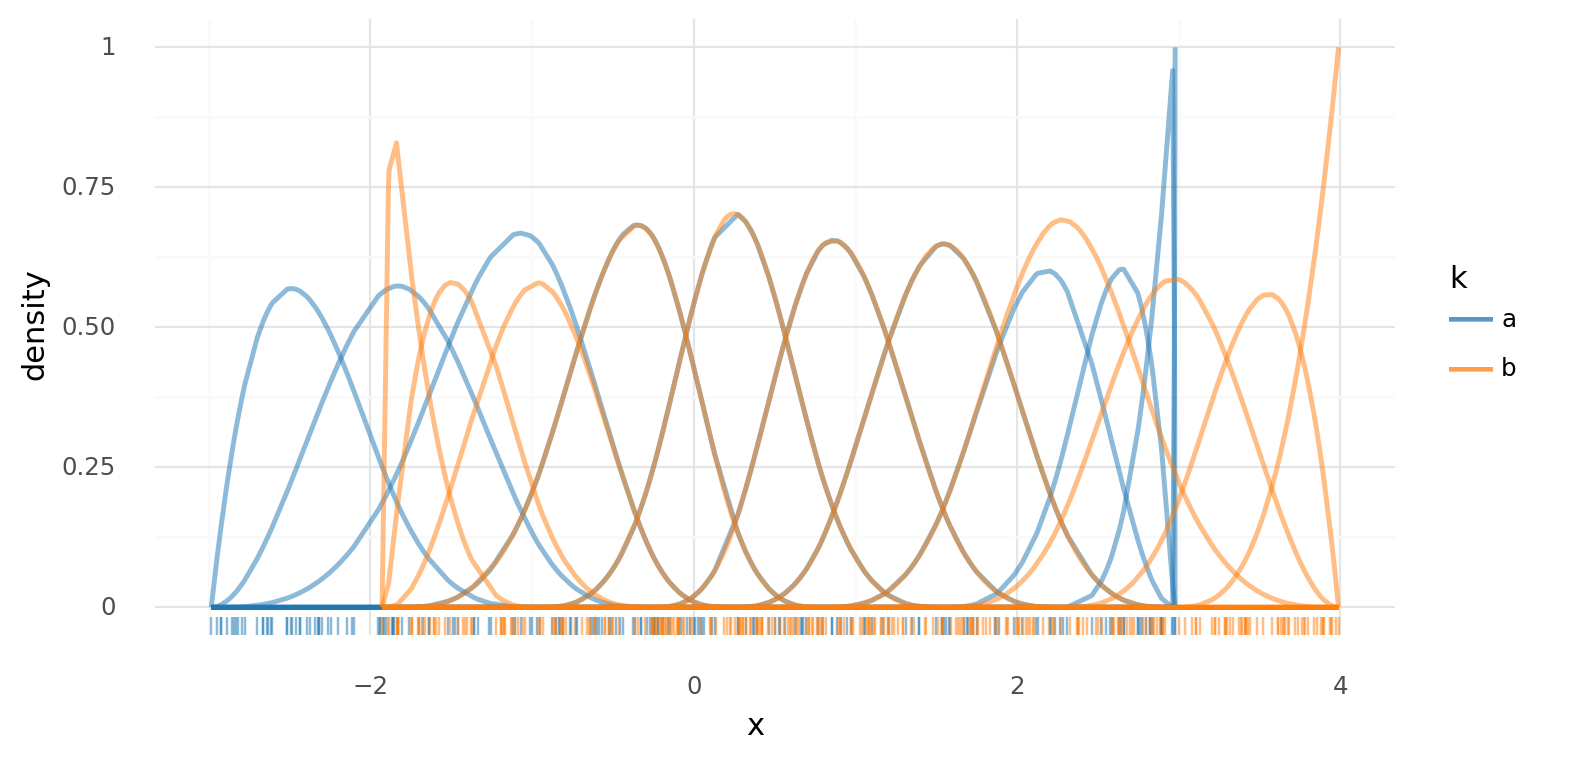

<ggplot: (347500526)>

In [44]:
basis_df = (
    pd.DataFrame(B_2)
    .assign(k=data2.k.values, x=data2.x.values)
    .pivot_longer(["k", "x"], names_to="basis", values_to="density")
    .assign(basis=lambda d: [f"{k}: {x}" for x, k in zip(d.basis, d.k)])
)
(
    gg.ggplot(basis_df, gg.aes(x="x", color="k"))
    + gg.geom_line(gg.aes(group="basis", y="density"), alpha=0.5, size=1)
    + gg.geom_rug(data=data2, alpha=0.5, sides="b")
    + gg.scale_color_manual(values=group_pal)
)

### Model #2

In [45]:
def build_model2(data: pd.DataFrame, B_k: list[np.ndarray]) -> pm.Model:
    B_dim = B_k[0].shape[1]
    k = data.k.cat.codes.values.astype(int)
    n_k = len(data.k.cat.categories)
    with pm.Model(rng_seeder=RANDOM_SEED) as m2:
        a = pm.Normal("a", 0, 5, shape=n_k)
        w = pm.Normal("w", 0, 5, shape=(B_dim, n_k))
        _mu = []
        for i in range(n_k):
            _mu.append(pm.math.dot(B_k[i], w[:, i]).reshape((-1, 1)))
        mu = pm.Deterministic("mu", a[k] + at.vertical_stack(*_mu).squeeze())
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y.values)

    return m2

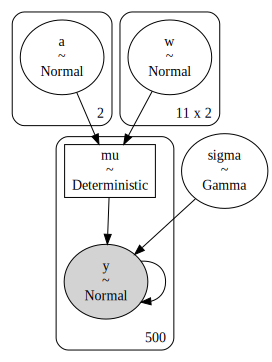

In [46]:
m2 = build_model2(data2, B_k)
pm.model_to_graphviz(m2)

### Sample from posterior

In [47]:
with build_model2(data=data2, B_k=B_k):
    m2_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m2_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior analysis

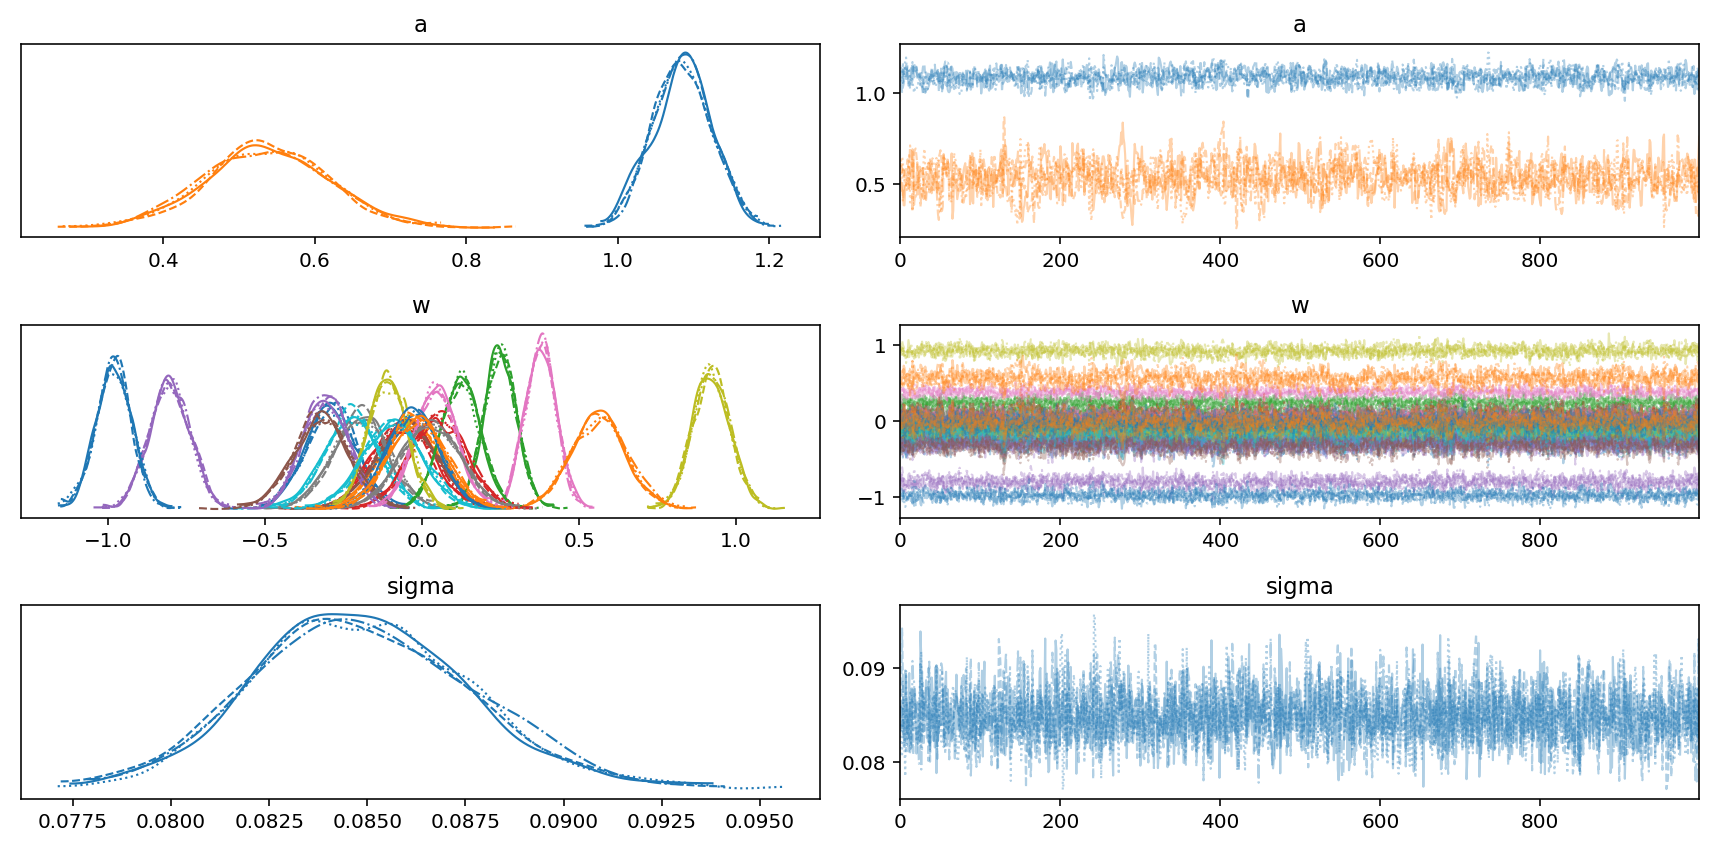

In [48]:
az.plot_trace(m2_trace, var_names=["~mu"])
plt.tight_layout();

In [49]:
az.summary(m2_trace, var_names=["~mu"], filter_vars="regex", hdi_prob=HDI_PROB)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a[0]      1.085  0.039     1.024      1.149      0.001    0.001    1223.0   
a[1]      0.537  0.082     0.402      0.664      0.003    0.002     933.0   
w[0, 0]  -0.291  0.080    -0.420     -0.163      0.002    0.002    1396.0   
w[0, 1]  -0.039  0.096    -0.191      0.113      0.003    0.002    1091.0   
w[1, 0]   0.249  0.052     0.161      0.325      0.001    0.001    3000.0   
w[1, 1]  -0.061  0.095    -0.202      0.099      0.003    0.002    1263.0   
w[2, 0]  -0.806  0.064    -0.908     -0.705      0.002    0.001    1542.0   
w[2, 1]  -0.049  0.096    -0.202      0.106      0.003    0.002    1144.0   
w[3, 0]   0.377  0.049     0.300      0.456      0.001    0.001    2024.0   
w[3, 1]  -0.196  0.088    -0.331     -0.050      0.003    0.002    1048.0   
w[4, 0]   0.921  0.059     0.827      1.017      0.001    0.001    1588.0   
w[4, 1]  -0.223  0.088    -0.377     -0.094      0.003    0.002    1027.0   
w[5, 0]  -0.983  0.057    -1.073     -0.890      0.001    0.001    2092.0   
w[5, 1]   0.562  0.089     0.414      0.697      0.003    0.002    1059.0   
w[6, 0]   0.122  0.063     0.024      0.224      0.001    0.001    1786.0   
w[6, 1]   0.050  0.090    -0.091      0.193      0.003    0.002    1065.0   
w[7, 0]  -0.310  0.072    -0.428     -0.203      0.002    0.001    2161.0   
w[7, 1]  -0.321  0.090    -0.464     -0.175      0.003    0.002    1066.0   
w[8, 0]   0.043  0.068    -0.070      0.145      0.002    0.001    2000.0   
w[8, 1]   0.026  0.095    -0.122      0.176      0.003    0.002    1169.0   
w[9, 0]  -0.111  0.062    -0.214     -0.018      0.001    0.001    1967.0   
w[9, 1]  -0.093  0.094    -0.243      0.060      0.003    0.002    1201.0   
w[10, 0] -0.029  0.083    -0.159      0.105      0.002    0.001    2693.0   
w[10, 1] -0.017  0.089    -0.162      0.122      0.003    0.002    1041.0   
sigma     0.085  0.003     0.080      0.089      0.000    0.000    3673.0   

          ess_tail  r_hat  
a[0]        1715.0    1.0  
a[1]        1148.0    1.0  
w[0, 0]     2260.0    1.0  
w[0, 1]     1479.0    1.0  
w[1, 0]     2795.0    1.0  
w[1, 1]     1836.0    1.0  
w[2, 0]     2279.0    1.0  
w[2, 1]     1700.0    1.0  
w[3, 0]     2650.0    1.0  
w[3, 1]     1528.0    1.0  
w[4, 0]     2441.0    1.0  
w[4, 1]     1379.0    1.0  
w[5, 0]     2368.0    1.0  
w[5, 1]     1401.0    1.0  
w[6, 0]     2129.0    1.0  
w[6, 1]     1458.0    1.0  
w[7, 0]     2944.0    1.0  
w[7, 1]     1403.0    1.0  
w[8, 0]     2324.0    1.0  
w[8, 1]     1824.0    1.0  
w[9, 0]     2805.0    1.0  
w[9, 1]     1522.0    1.0  
w[10, 0]    2363.0    1.0  
w[10, 1]    1506.0    1.0  
sigma       2649.0    1.0

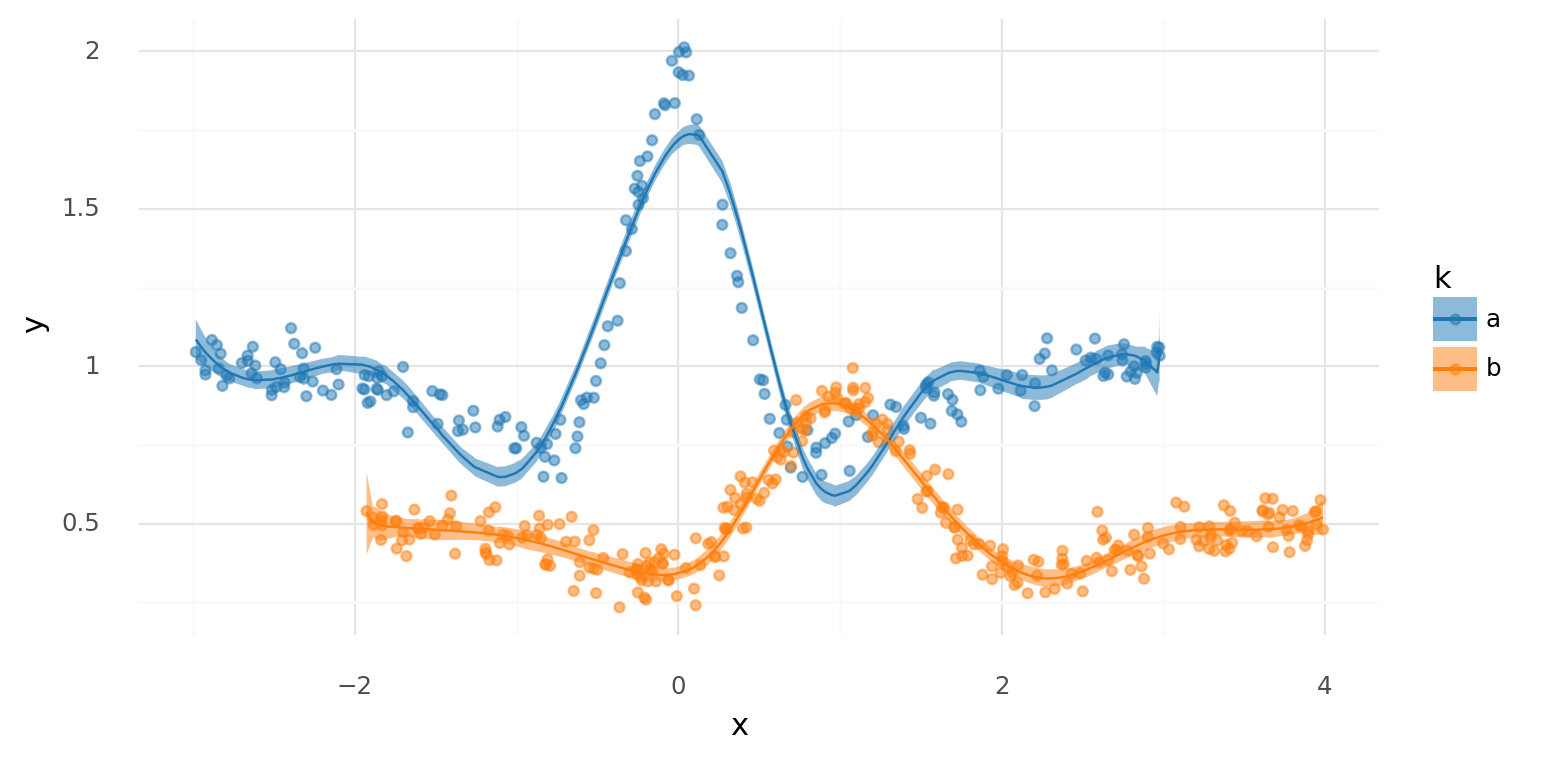

<ggplot: (349005788)>

In [50]:
_plot_posterior_mu(m2_trace, data=data2)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_2877/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


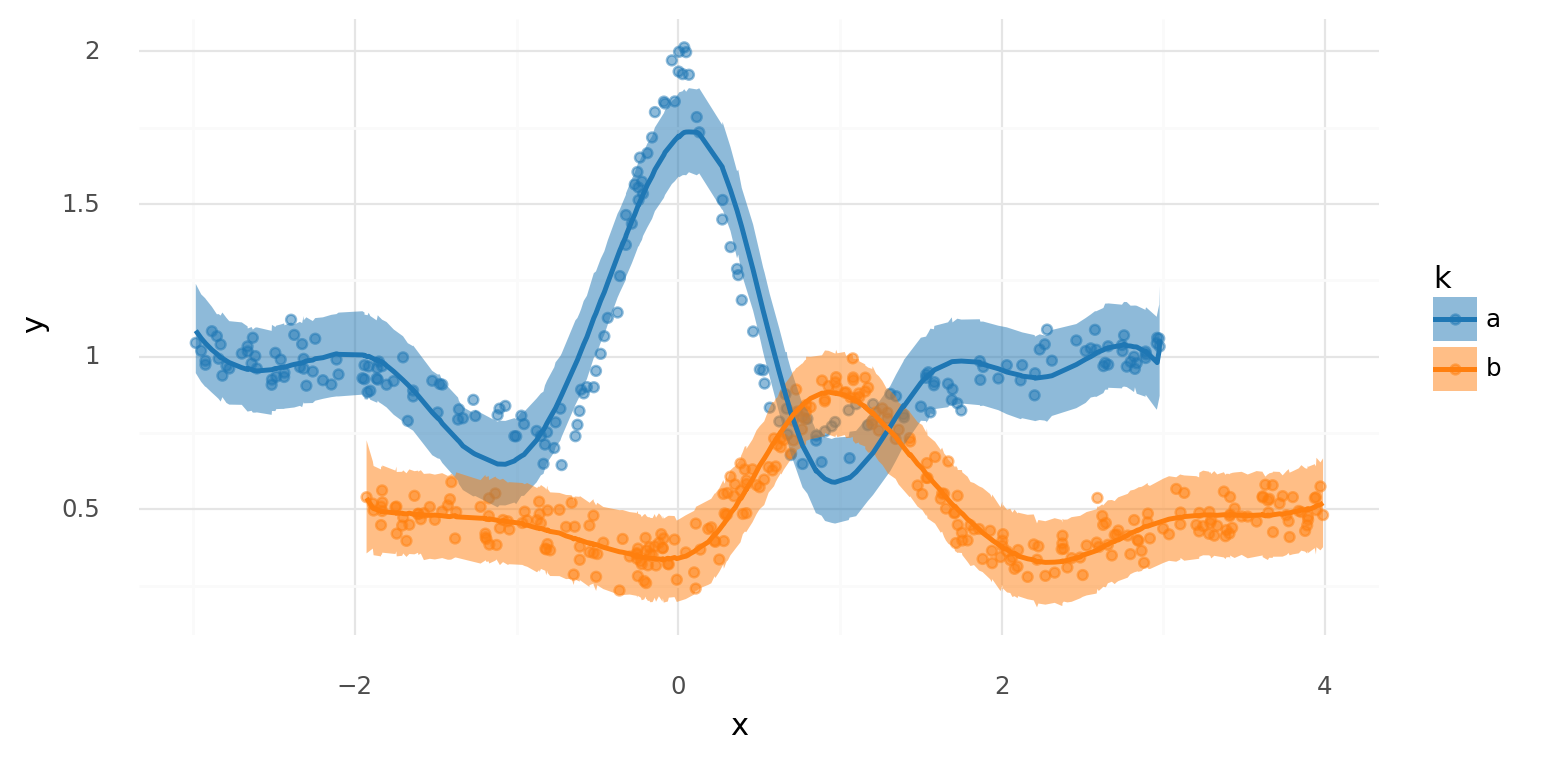

<ggplot: (348733636)>

In [51]:
_plot_ppc(m2_trace, data2)

## Multi-group, single spline basis

### Spline basis

In [52]:
knot3, B3 = _build_spline(data2)

### Model #3

In [53]:
def build_model3(data: pd.DataFrame, B: np.ndarray) -> pm.Model:
    B_dim = B.shape[1]
    k = data.k.cat.codes.values.astype(int)
    n_k = len(data.k.cat.categories)
    with pm.Model(rng_seeder=RANDOM_SEED) as m3:
        a = pm.Normal("a", 0, 5, shape=n_k)
        w = pm.Normal("w", 0, 5, shape=(B_dim, n_k))
        _mu = []
        for i in range(n_k):
            _mu.append(pm.math.dot(B[k == i], w[:, i]).reshape((-1, 1)))
        mu = pm.Deterministic("mu", a[k] + at.vertical_stack(*_mu).squeeze())
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y.values)

    return m3

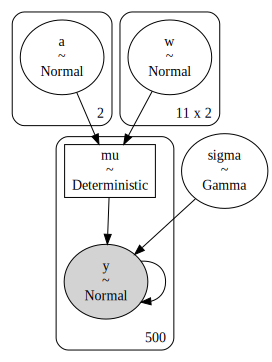

In [54]:
m3 = build_model3(data2, B3)
pm.model_to_graphviz(m3)

### Sample from posterior

In [ ]:
with build_model3(data=data2, B=np.asarray(B3)):
    m3_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m3_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


### Posterior analysis

In [ ]:
az.plot_trace(m3_trace, var_names=["~mu"])
plt.tight_layout();

In [ ]:
az.summary(m3_trace, var_names=["~mu"], filter_vars="regex", hdi_prob=HDI_PROB)

In [ ]:
_plot_posterior_mu(m3_trace, data=data2)

In [ ]:
_plot_ppc(m3_trace, data2)

### Out-of-distribution predictions

In [ ]:
new_data3, new_B3 = _build_new_data(data2, B=B3, knots=knot3, n_x=500)
new_data3 = pd.concat([new_data3.assign(k=k) for k in ["a", "b"]]).reset_index(
    drop=True
)
new_data3["k"] = pd.Categorical(new_data3["k"], categories=["a", "b"], ordered=True)
new_B3_array = np.vstack([np.asarray(new_B3) for _ in ["a", "b"]])

In [ ]:
with build_model3(new_data3, B=new_B3_array):
    m3_post_pred_new = pm.sample_posterior_predictive(
        trace=m3_trace,
        var_names=["mu", "y"],
        return_inferencedata=True,
        extend_inferencedata=False,
    )

In [ ]:
_plot_ppc(m3_post_pred_new, new_data3, pt_alpha=0)

## Hierarchical prior on multi-group spline

### Model #4

In [84]:
def build_model4(data: pd.DataFrame, B: np.ndarray) -> pm.Model:
    B_dim = B.shape[1]
    k = data.k.cat.codes.values.astype(int)
    n_k = len(data.k.cat.categories)
    with pm.Model(rng_seeder=RANDOM_SEED) as m4:
        mu_w = pm.Normal("mu_w", mu=0, sigma=5, shape=(B_dim, 1))
        sigma_w = pm.Gamma("sigma_w", 2.0, 0.5)
        w = pm.Normal(
            "w",
            at.horizontal_stack(*[mu_w for _ in range(n_k)]),
            sigma_w,
            shape=(B_dim, n_k),
        )
        _mu = []
        for i in range(n_k):
            _mu.append(pm.math.dot(B[k == i], w[:, i]).reshape((-1, 1)))
        mu = pm.Deterministic("mu", at.vertical_stack(*_mu).squeeze())
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y.values)

    return m4

In [85]:
m4 = build_model4(data2, B3)
pm.model_to_graphviz(m4)

NameError: name 'B3' is not defined

### Sample from posterior

In [66]:
with build_model4(data=data2, B=np.asarray(B3)):
    m4_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m4_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_w, sigma_w, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.


### Posterior analysis

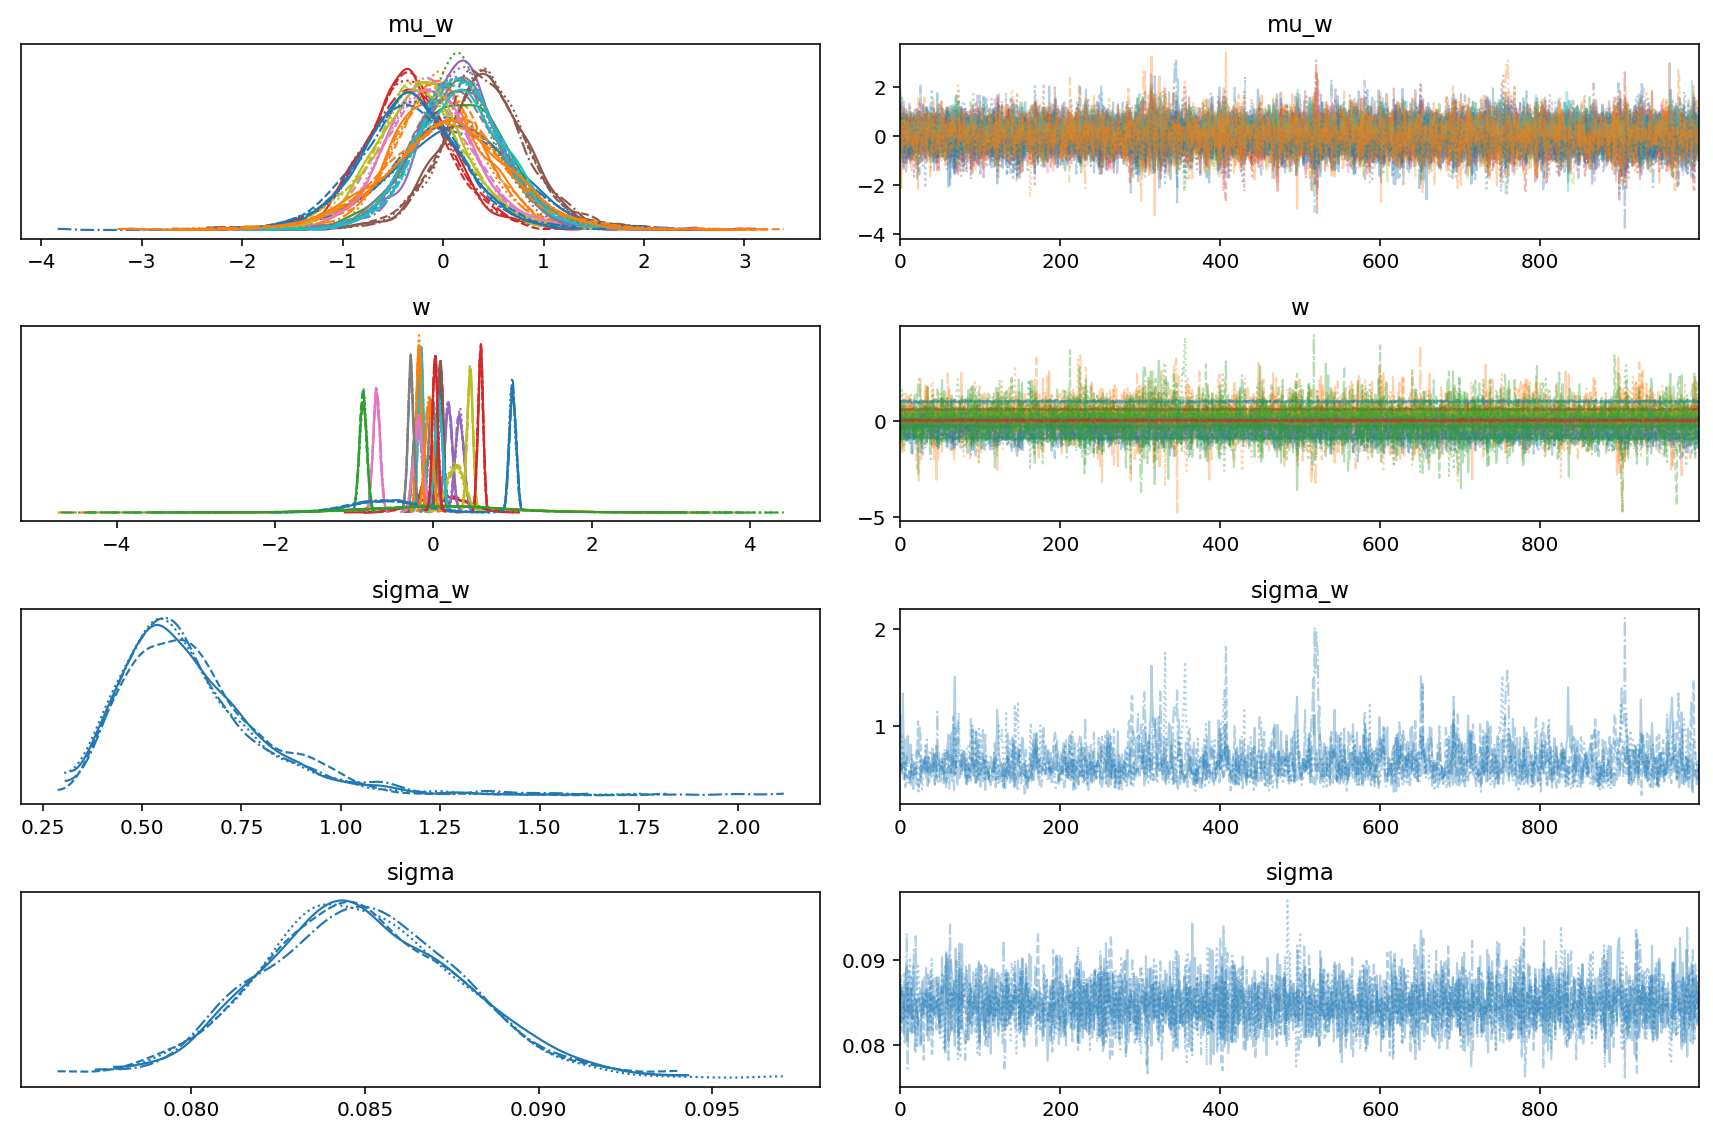

In [67]:
az.plot_trace(m4_trace, var_names=["~mu"])
plt.tight_layout();

In [68]:
az.summary(m4_trace, var_names=["~mu"], filter_vars="regex", hdi_prob=HDI_PROB)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
w[0, 0]   0.083  0.039     0.018      0.142      0.001    0.000    4444.0   
w[0, 1]   0.086  0.905    -1.281      1.555      0.015    0.016    4013.0   
w[1, 0]  -0.203  0.050    -0.283     -0.128      0.001    0.001    2899.0   
w[1, 1]   0.102  0.302    -0.404      0.565      0.006    0.005    2708.0   
w[2, 0]   0.331  0.053     0.246      0.414      0.001    0.001    2737.0   
w[2, 1]  -0.031  0.095    -0.184      0.120      0.002    0.001    2335.0   
w[3, 0]  -0.719  0.043    -0.789     -0.649      0.001    0.001    2983.0   
w[3, 1]  -0.014  0.044    -0.086      0.056      0.001    0.001    2229.0   
w[4, 0]   0.463  0.037     0.403      0.518      0.001    0.000    2851.0   
w[4, 1]  -0.158  0.032    -0.214     -0.111      0.001    0.000    2654.0   
w[5, 0]   1.001  0.041     0.939      1.070      0.001    0.001    2947.0   
w[5, 1]  -0.185  0.030    -0.234     -0.138      0.001    0.000    2798.0   
w[6, 0]  -0.889  0.044    -0.959     -0.819      0.001    0.001    3085.0   
w[6, 1]   0.596  0.032     0.539      0.644      0.001    0.000    2696.0   
w[7, 0]   0.190  0.047     0.111      0.261      0.001    0.001    2648.0   
w[7, 1]   0.090  0.035     0.031      0.142      0.001    0.000    2573.0   
w[8, 0]  -0.195  0.058    -0.289     -0.105      0.001    0.001    2401.0   
w[8, 1]  -0.286  0.036    -0.339     -0.224      0.001    0.001    2419.0   
w[9, 0]   0.283  0.107     0.111      0.451      0.002    0.002    2290.0   
w[9, 1]   0.066  0.048    -0.006      0.147      0.001    0.001    2198.0   
w[10, 0] -0.614  0.426    -1.322      0.026      0.008    0.006    2548.0   
w[10, 1] -0.060  0.047    -0.134      0.017      0.001    0.001    2558.0   
w[11, 0]  0.045  0.906    -1.421      1.359      0.015    0.016    3901.0   
w[11, 1]  0.021  0.034    -0.030      0.077      0.001    0.000    3548.0   
sigma_w   0.625  0.185     0.365      0.870      0.006    0.004    1075.0   
sigma     0.085  0.003     0.080      0.089      0.000    0.000    5613.0   

          ess_tail  r_hat  
w[0, 0]     3472.0    1.0  
w[0, 1]     2476.0    1.0  
w[1, 0]     3117.0    1.0  
w[1, 1]     2802.0    1.0  
w[2, 0]     2825.0    1.0  
w[2, 1]     2636.0    1.0  
w[3, 0]     3094.0    1.0  
w[3, 1]     2389.0    1.0  
w[4, 0]     2907.0    1.0  
w[4, 1]     2745.0    1.0  
w[5, 0]     3483.0    1.0  
w[5, 1]     2932.0    1.0  
w[6, 0]     3103.0    1.0  
w[6, 1]     3066.0    1.0  
w[7, 0]     2815.0    1.0  
w[7, 1]     2881.0    1.0  
w[8, 0]     2941.0    1.0  
w[8, 1]     2878.0    1.0  
w[9, 0]     2788.0    1.0  
w[9, 1]     2583.0    1.0  
w[10, 0]    2733.0    1.0  
w[10, 1]    2383.0    1.0  
w[11, 0]    2439.0    1.0  
w[11, 1]    3096.0    1.0  
sigma_w     1353.0    1.0  
sigma       2798.0    1.0

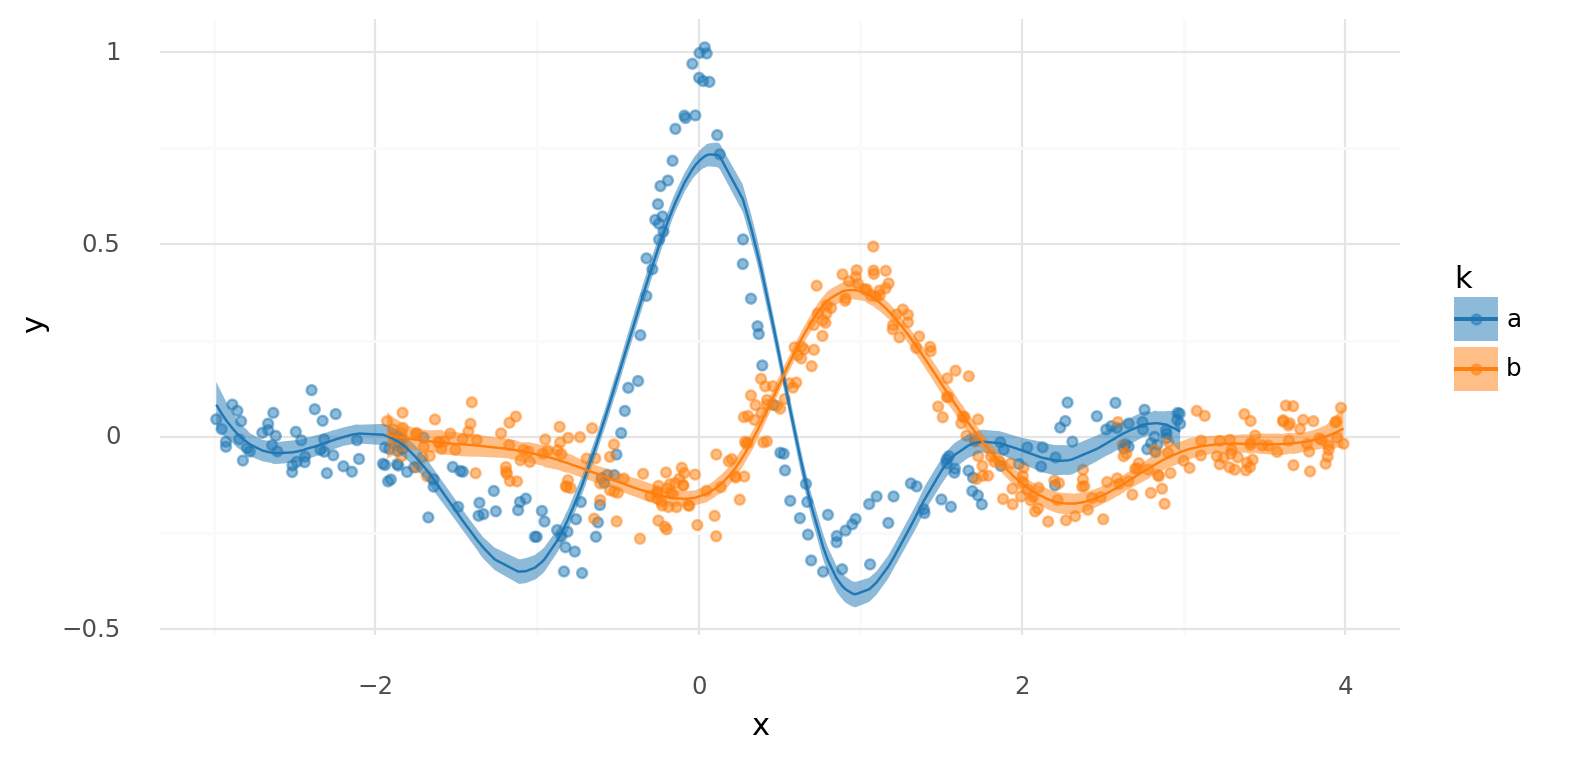

<ggplot: (346657949)>

In [69]:
_plot_posterior_mu(m4_trace, data=data2)

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_38106/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


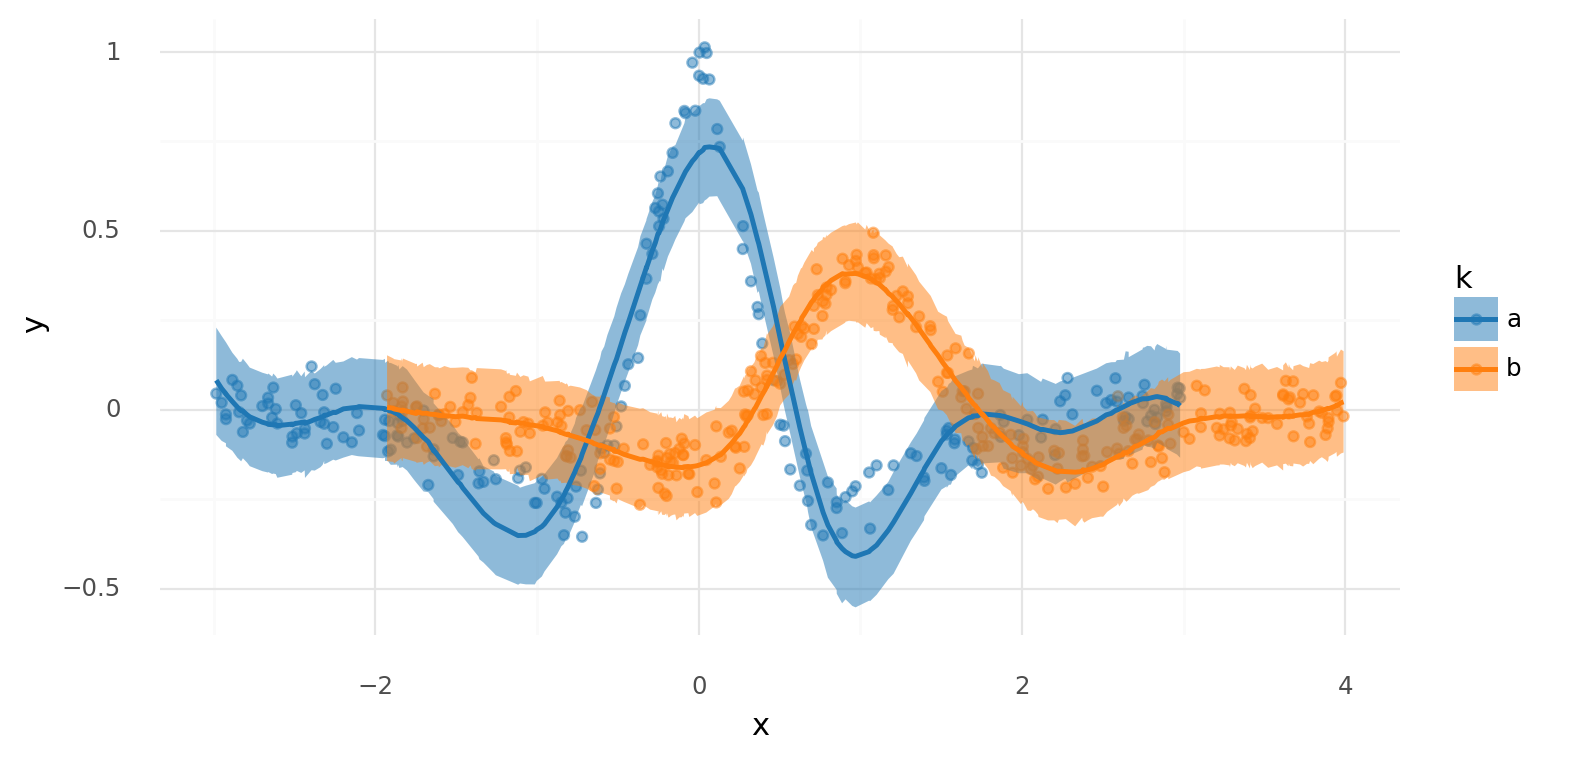

<ggplot: (347865853)>

In [70]:
_plot_ppc(m4_trace, data2)

### Out-of-distribution predictions

In [71]:
with build_model4(new_data3, B=new_B3_array):
    m4_post_pred_new = pm.sample_posterior_predictive(
        trace=m4_trace,
        var_names=["mu", "y"],
        return_inferencedata=True,
        extend_inferencedata=False,
    )

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_38106/2876986528.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/si

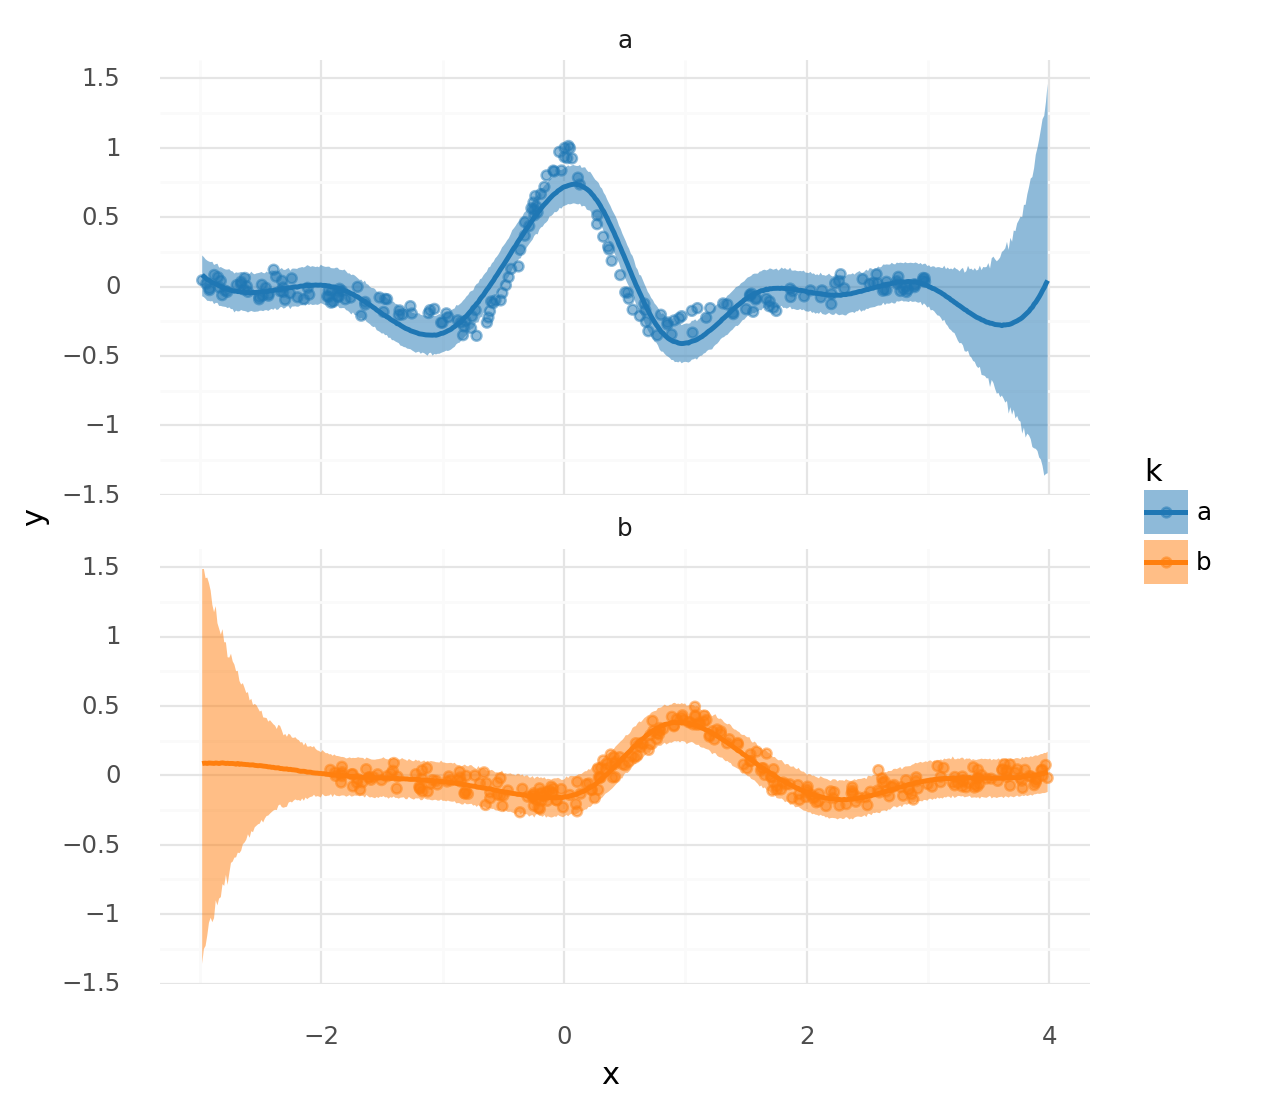

<ggplot: (349094946)>

In [72]:
(
    _plot_ppc(m4_post_pred_new, new_data3, pt_alpha=0)
    + gg.facet_wrap("~k", ncol=1)
    + gg.geom_point(gg.aes(x="x", y="y", color="k"), data=data2, alpha=0.5)
    + gg.theme(figure_size=(6, 6))
)

## Hierarchical multivariate-normal prior (single group)

> Experiment with this in the future. The goal is to include in the prior that neighboring spline bases will be correlated.

### Model #5 simple

In [266]:
def build_model5_simple(data: pd.DataFrame, B: np.ndarray) -> pm.Model:
    B_dim = B.shape[1]
    with pm.Model(rng_seeder=RANDOM_SEED) as m5:
        mu_w = pm.Normal("mu_w", 0, 2.5)
        sigma_w = pm.Gamma("sigma_w", 2, 0.5)
        a = pm.Normal("a", 0, 5)
        w = pm.Normal("w", mu_w, sigma_w, shape=B_dim)
        mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B), w.T))
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y)
    return m5

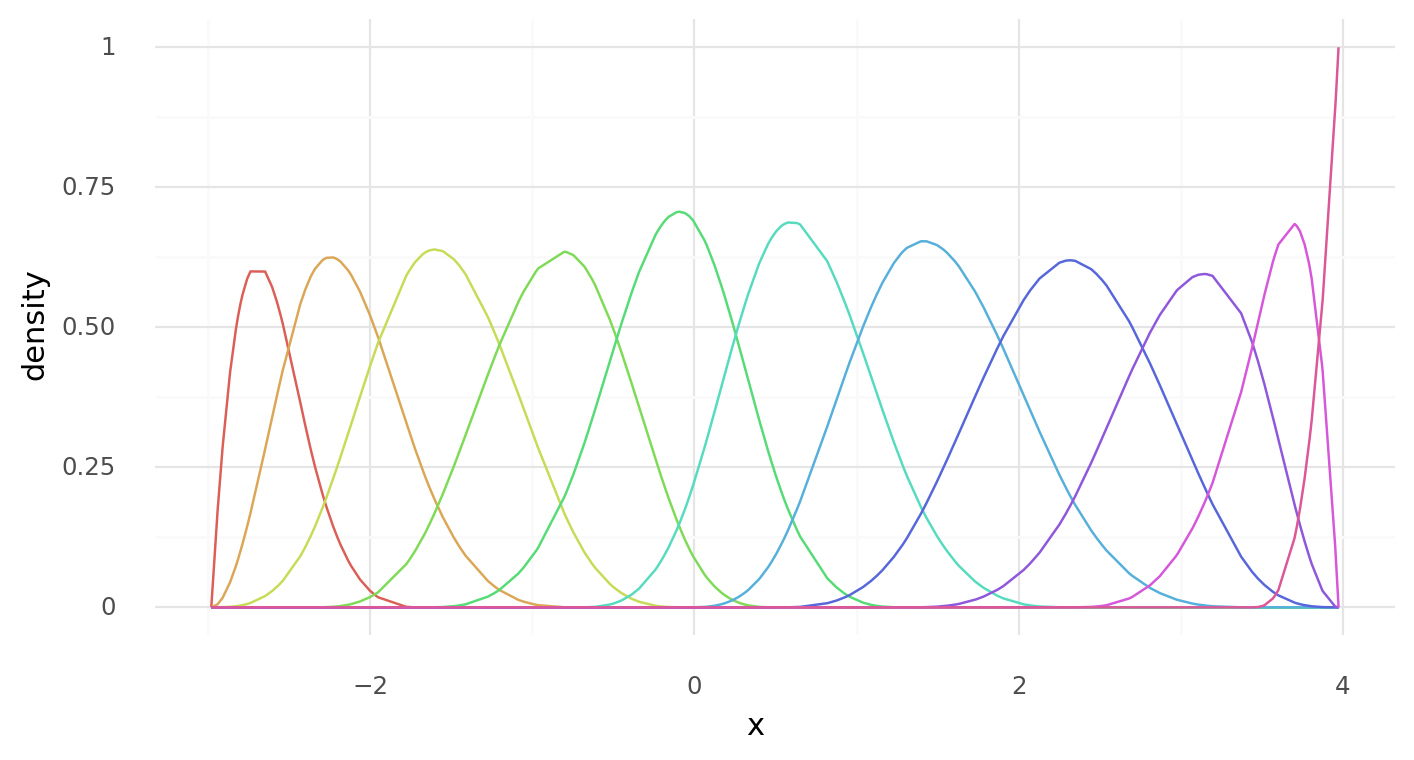

<ggplot: (371145686)>

In [268]:
basis_df = (
    pd.DataFrame(np.asarray(B))
    .reset_index(drop=False)
    .assign(x=data.x.values)
    .pivot_longer(index=["index", "x"], names_to="basis", values_to="density")
)

(
    gg.ggplot(basis_df, gg.aes(x="x", y="density", color="basis"))
    + gg.geom_line()
    + gg.theme(legend_position="none")
)

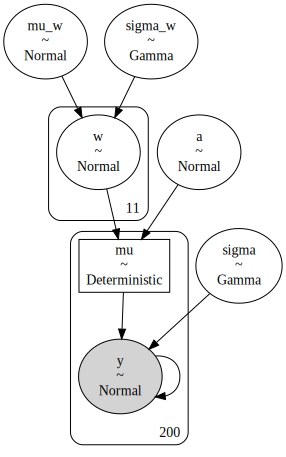

In [269]:
m5_s = build_model5_simple(data, B)
pm.model_to_graphviz(m5_s)

### Sample from posterior

In [270]:
with build_model5_simple(data=data, B=np.asarray(m5_s_B)):
    m5_s_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m5_s_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_w, sigma_w, a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
The number of effective samples is smaller than 25% for some parameters.


### Posterior analysis

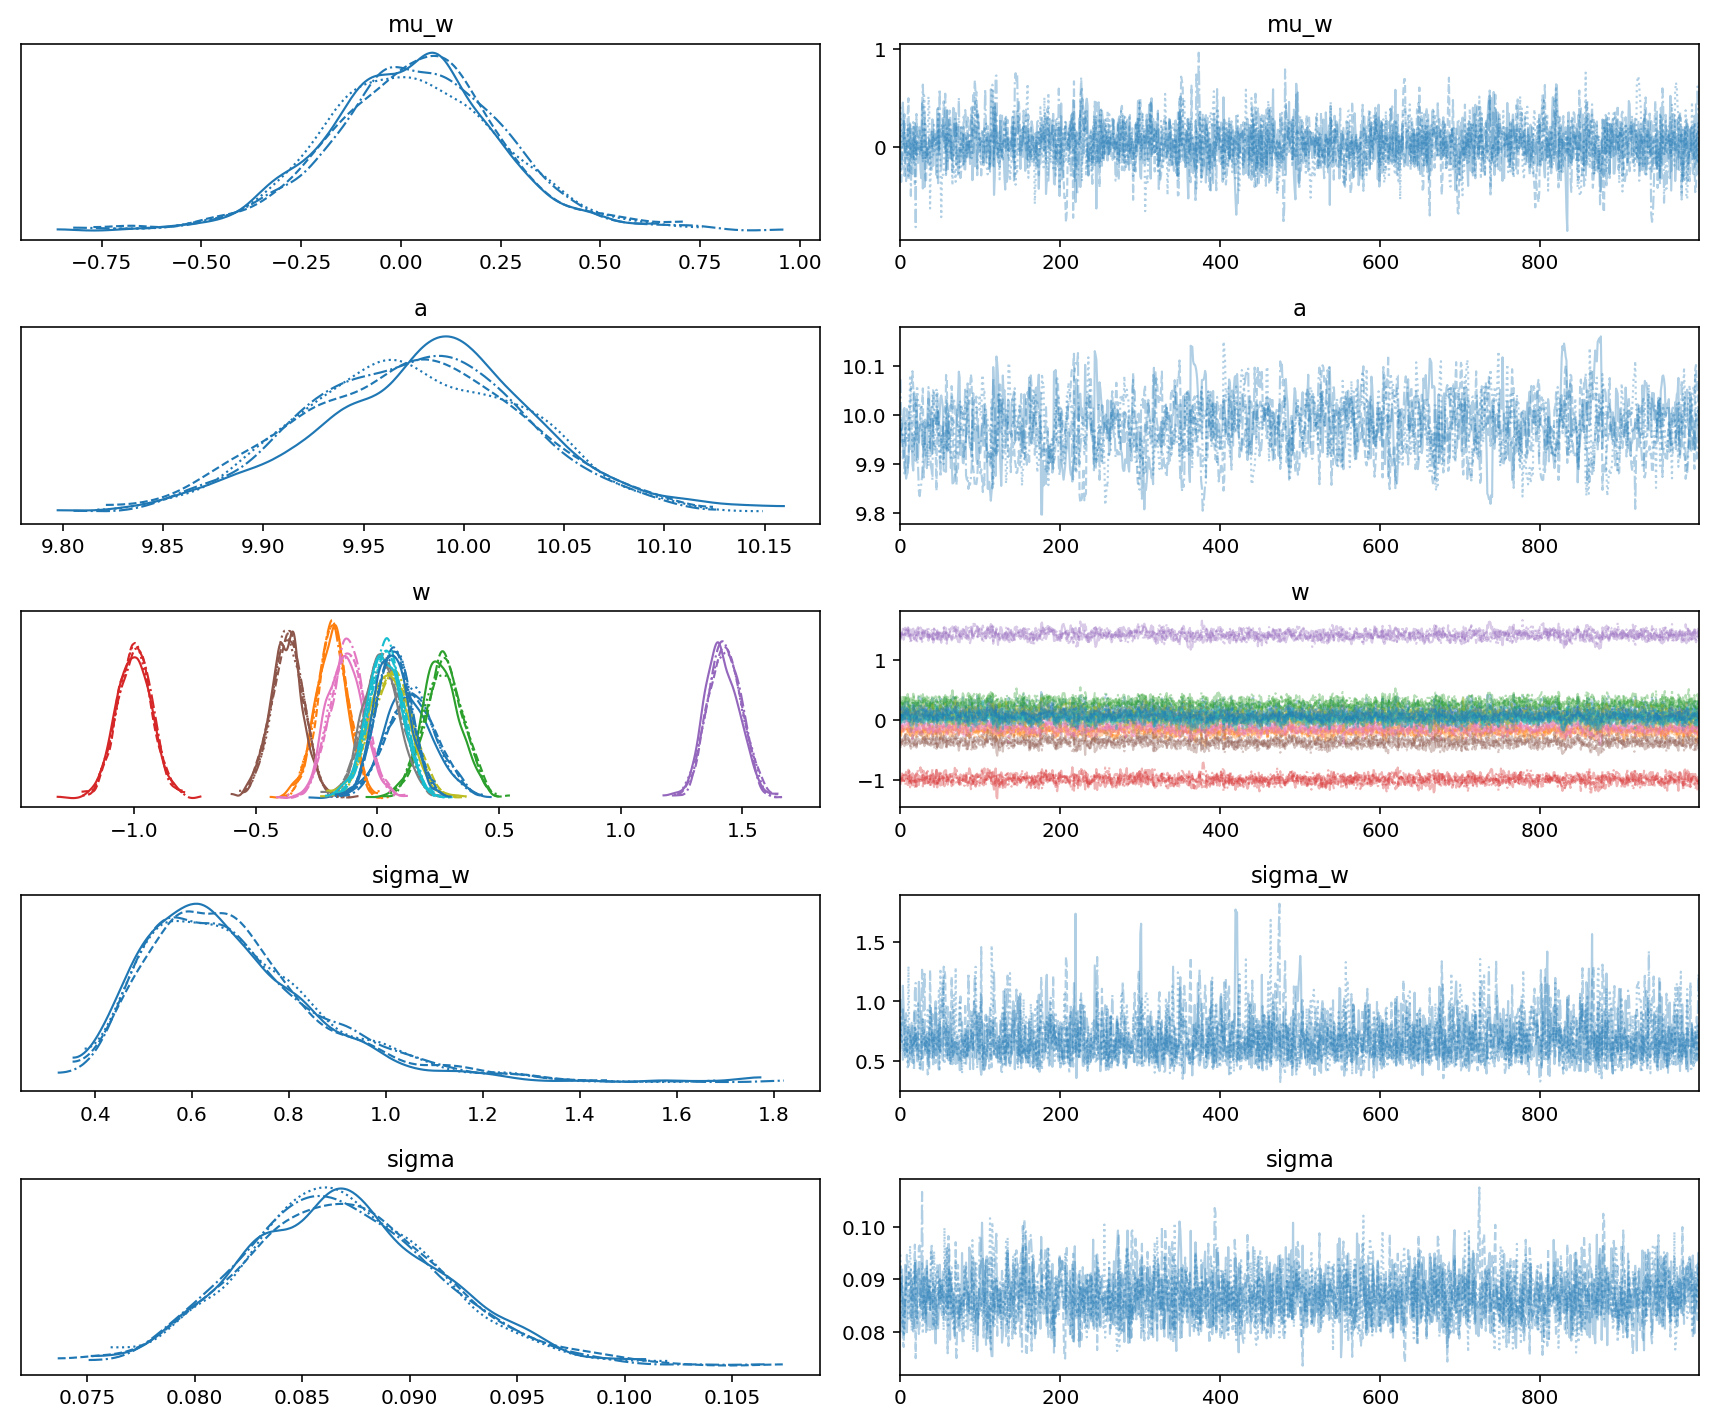

In [271]:
az.plot_trace(m5_s_trace, var_names=["~mu"])
plt.tight_layout();

### Model #5 multivariate normal

In [182]:
def build_model5_mv(data: pd.DataFrame, B: np.ndarray) -> pm.Model:
    B_dim = B.shape[1]
    _B_ary = np.asarray(B)
    with pm.Model(rng_seeder=RANDOM_SEED) as m5_mv:
        _sd_dist = pm.Gamma.dist(2, 0.5, shape=B_dim)
        chol, corr, stds = pm.LKJCholeskyCov(
            "chol", eta=2, n=B_dim, sd_dist=_sd_dist, compute_corr=True
        )
        cov = pm.Deterministic("cov", chol.dot(chol.T))

        mu_w = pm.Normal("mu_w", 0, 2.5, shape=B_dim)
        delta_w = pm.Normal("delta_w", 0, 1, shape=B_dim)
        # w = pm.MvNormal("w", mu=mu_w, chol=chol, shape=B_dim)
        w = pm.Deterministic("w", mu_w + at.dot(chol, delta_w.T).T)

        mu = pm.Deterministic("mu", pm.math.dot(_B_ary, w))
        sigma = pm.Gamma("sigma", 2, 0.5)
        y = pm.Normal("y", mu, sigma, observed=data.y)
    return m5_mv

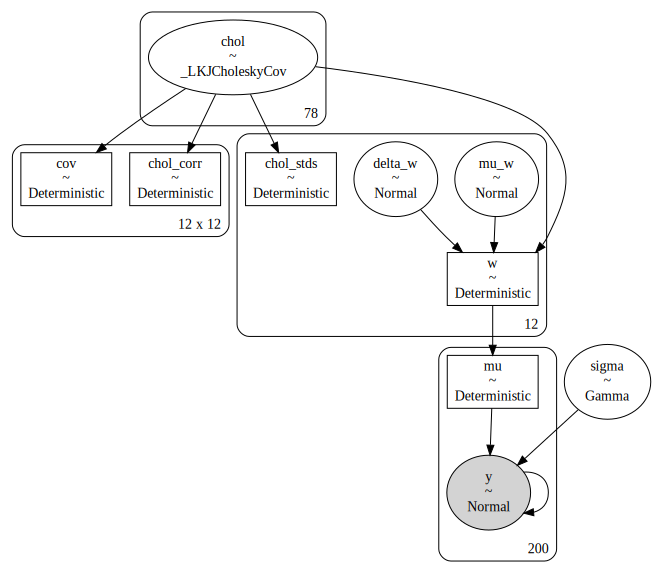

In [183]:
m5_mv = build_model5_mv(data, B)
pm.model_to_graphviz(m5_mv)

### Sample from posterior

In [184]:
with build_model5_mv(data=data, B=np.asarray(B)):
    m5_mv_trace = pm.sample(**pm_sample_kwargs)
    pm.sample_posterior_predictive(m5_mv_trace, **pm_ppc_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, mu_w, delta_w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1376 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


### Posterior analysis

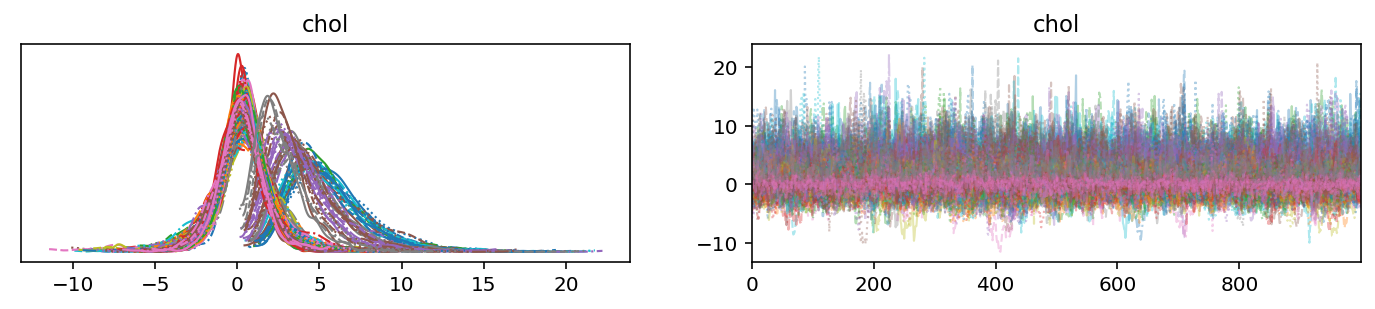

In [188]:
az.plot_trace(m5_mv_trace, var_names=["chol"]);

In [189]:
# az.plot_trace(m5_mv_trace, var_names=["~mu", "~delta_w"])
# plt.tight_layout();

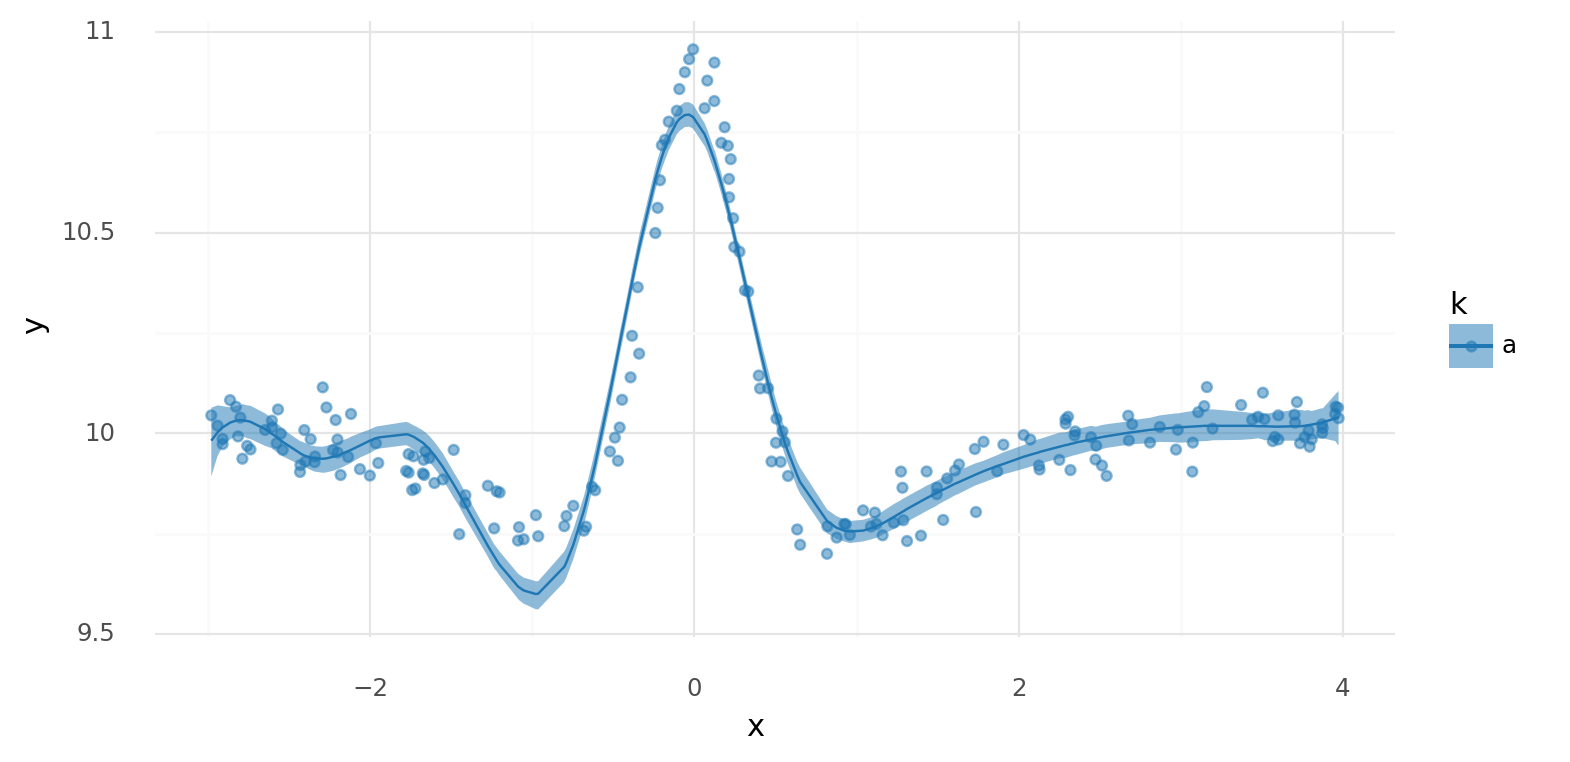

<ggplot: (360906632)>

In [190]:
_plot_posterior_mu(m5_s_trace, data=data)

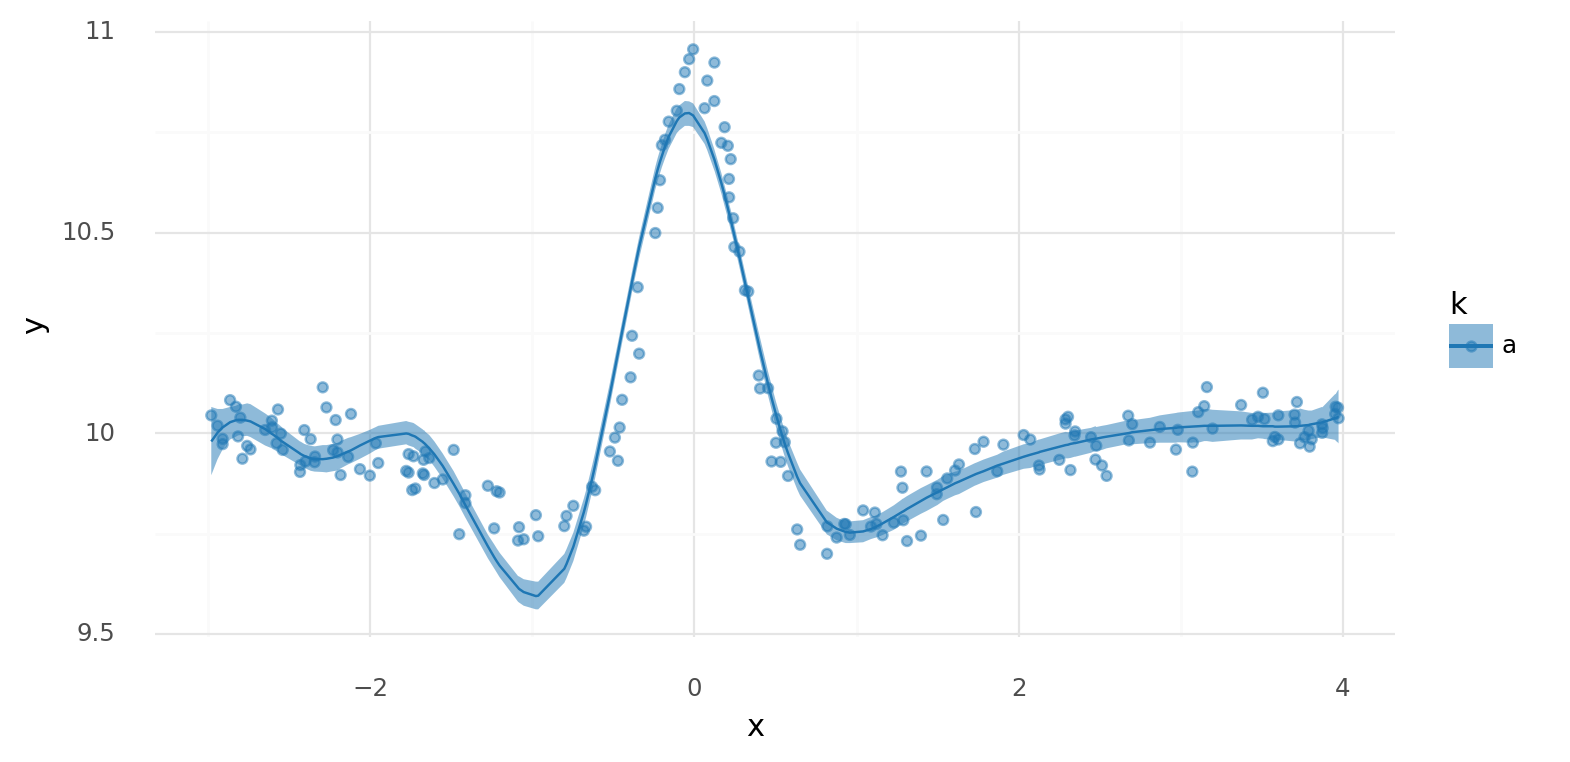

<ggplot: (360895413)>

In [191]:
_plot_posterior_mu(m5_mv_trace, data=data)

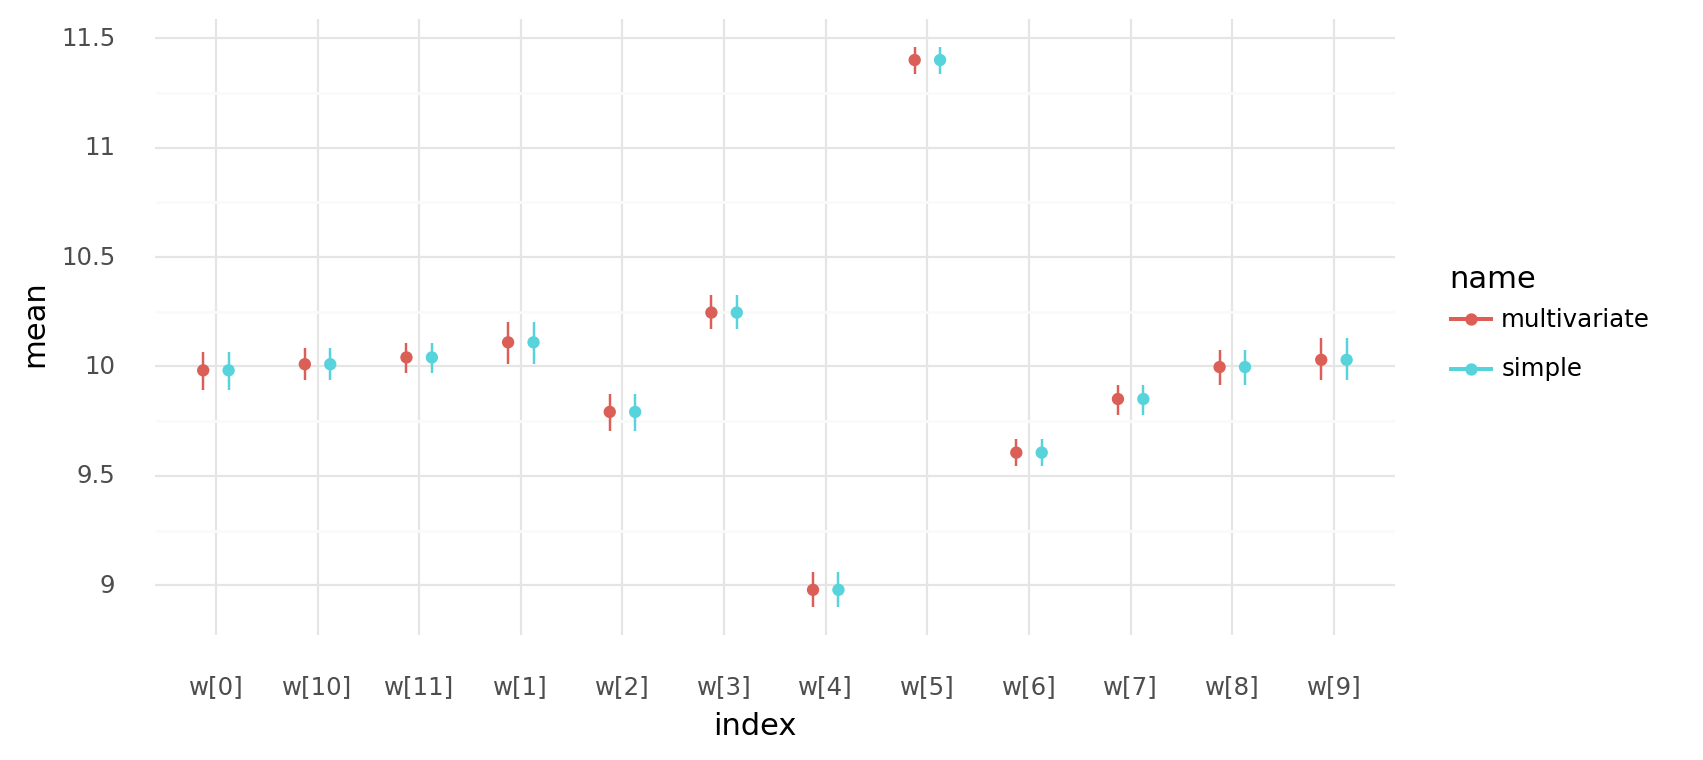

<ggplot: (360839506)>

In [192]:
w_post_combined = pd.concat(
    [
        az.summary(m5_s_trace, var_names=["w"], kind="stats", hdi_prob=HDI_PROB).assign(
            name=n
        )
        for n, t in {"simple": m5_s_trace, "multivariate": m5_mv_trace}.items()
    ]
).reset_index(drop=False)

pos = gg.position_dodge(0.5)
(
    gg.ggplot(w_post_combined, gg.aes(x="index", y="mean", color="name"))
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), position=pos)
    + gg.geom_point(position=pos)
)

In [204]:
cov_post_df = (
    az.summary(m5_mv_trace, var_names=["cov"], hdi_prob=HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "parameter"})
    .assign(_idx=lambda d: [list(re.findall("[0-9]+", x)) for x in d.parameter])
    .assign(
        d0=lambda d: [int(x[0]) for x in d["_idx"]],
        d1=lambda d: [int(x[1]) for x in d["_idx"]],
    )
)
cov_post_df.head()

parameter    mean      sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0  cov[0, 0]  39.864  36.979     1.973     80.004      1.670    1.182   
1  cov[0, 1]   3.312   9.167   -10.967     16.396      0.373    0.264   
2  cov[0, 2]   2.651  10.406   -12.795     15.994      0.426    0.301   
3  cov[0, 3]   3.092  11.069   -10.014     20.573      0.512    0.365   
4  cov[0, 4]   2.991   9.429   -10.982     15.637      0.508    0.359   

   ess_bulk  ess_tail  r_hat    _idx  d0  d1  
0     353.0     636.0   1.01  [0, 0]   0   0  
1     592.0     831.0   1.01  [0, 1]   0   1  
2     680.0     666.0   1.01  [0, 2]   0   2  
3     608.0     386.0   1.00  [0, 3]   0   3  
4     509.0     414.0   1.01  [0, 4]   0   4

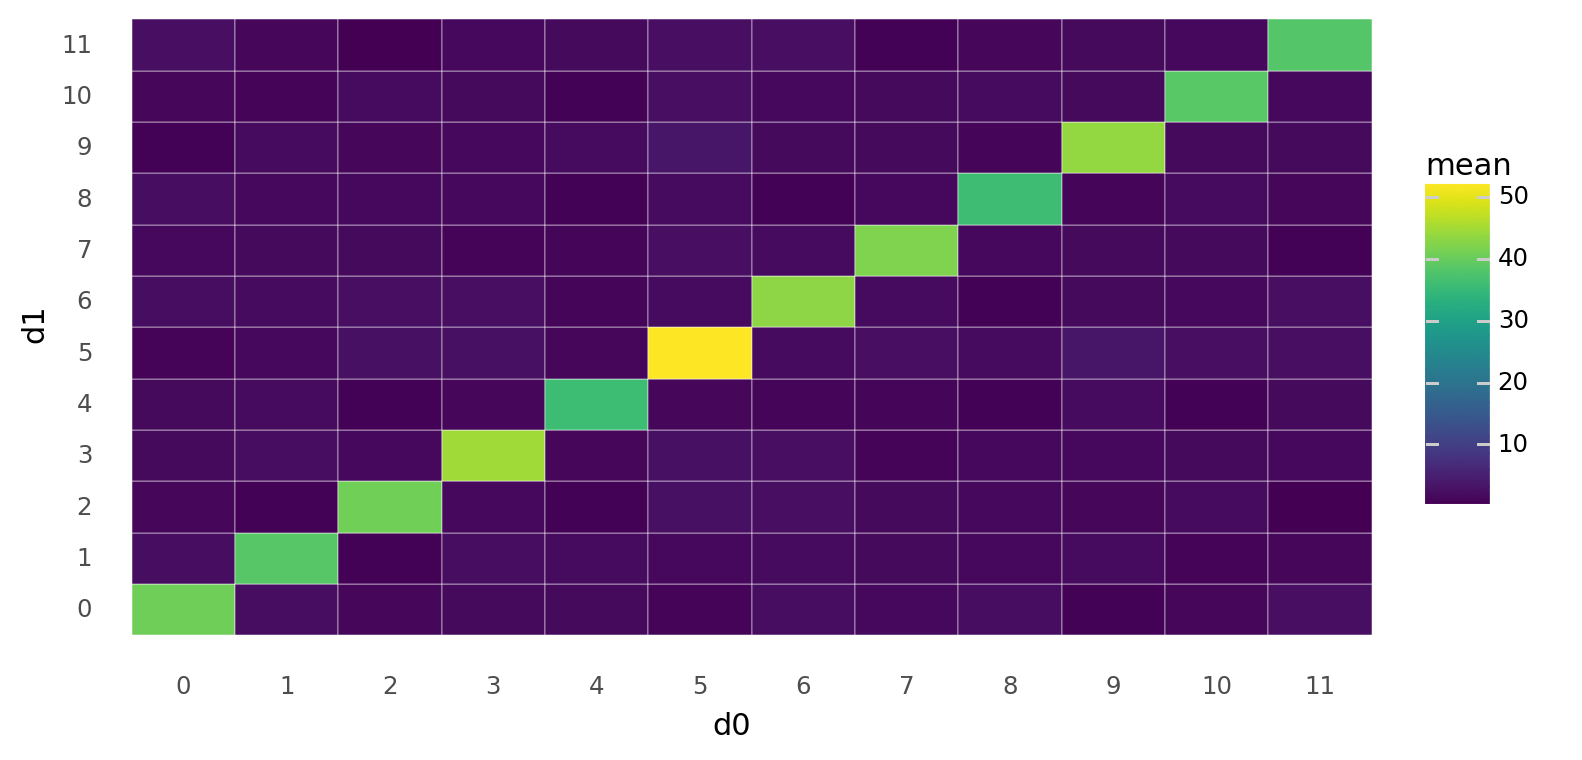

<ggplot: (362921500)>

In [212]:
(
    gg.ggplot(cov_post_df, gg.aes(x="d0", y="d1"))
    + gg.geom_tile(gg.aes(fill="mean"), color="white")
    + gg.scale_x_continuous(expand=(0, 0), breaks=np.arange(0, 100))
    + gg.scale_y_continuous(expand=(0, 0), breaks=np.arange(0, 100))
)

---

## Session info

In [77]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-02-21

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: add-nb-model

plotnine  : 0.8.0
pandas    : 1.4.1
arviz     : 0.11.4
matplotlib: 3.5.1
pymc      : 4.0.0b2
aesara    : 2.3.8
janitor   : 0.22.0
scipy     : 1.7.3
seaborn   : 0.11.2
numpy     : 1.22.2

